<a href="https://colab.research.google.com/github/dilgc/AIM460GroupProject1/blob/main/Dilger_Imran_Group_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Group Project 1 - Diabetes**
By Charles Dilger and Ahsan Imran
# ____________________________________________

Our target variable for this assignment will be the outcome, whether the individual had diabetes or not. We will be experimenting with many different models, and trying to maximize the performance metrics.
We will start off by:


*   Loading the dataset from Github
*   Visualizing the immediate data
*   Checking for null values in the data



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Import the diabetes.csv file from Github
url = "https://raw.githubusercontent.com/MatthewFried/AIM_460/main/HW%20Folder/AIM460%20Group%20Project%201%20data%20-%20diabetes.csv"
df = pd.read_csv(url)

# Print basic information about the dataset
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

print("\nDataset info:")
print(df.info())

print("\nColumn names:")
print(df.columns.tolist())

Dataset shape: (768, 9)

First few rows:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               76

In [ ]:
# Create a confusion matrix using crosstab
# Assuming we need to create predictions first (since raw data has no predictions)
# Using a simple glucose threshold as example
df['predicted'] = (df['Glucose'] > df['Glucose'].median()).astype(int)
confusion_matrix = pd.crosstab(df['Outcome'], df['predicted'])
print("Confusion Matrix:")
print(confusion_matrix)

# Extract individual confusion matrix values
# confusion_matrix structure:
#           predicted
# Outcome     0    1
#       0    TN   FP
#       1    FN   TP

TN = confusion_matrix.loc[0, 0]  # True Negative
FP = confusion_matrix.loc[0, 1]  # False Positive
FN = confusion_matrix.loc[1, 0]  # False Negative
TP = confusion_matrix.loc[1, 1]  # True Positive

print(f"\nExtracted Confusion Matrix Values:")
print(f"True Negative (TN): {TN}")
print(f"False Positive (FP): {FP}")
print(f"False Negative (FN): {FN}")
print(f"True Positive (TP): {TP}")

# Check value_counts for the columns used in crosstab
print("\nValue counts for Outcome (actual):")
print(df['Outcome'].value_counts())
print("\nValue counts for predicted:")
print(df['predicted'].value_counts())


Confusion Matrix:
predicted    0    1
Outcome            
0          327  173
1           64  204

Extracted Confusion Matrix Values:
True Negative (TN): 327
False Positive (FP): 173
False Negative (FN): 64
True Positive (TP): 204

Value counts for Outcome (actual):
Outcome
0    500
1    268
Name: count, dtype: int64

Value counts for predicted:
predicted
0    391
1    377
Name: count, dtype: int64


In [ ]:
# Create chart of null values for all features
null_counts = df.isnull().sum()
print("\nNull Values by Feature:")
print(null_counts)


Null Values by Feature:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
predicted                   0
dtype: int64


There were no null values within the data, so we need not worry about null values affecting the data. Let's continue with a comprehensive EDA, starting with histograms of the relationship between each feature, and our target variable.

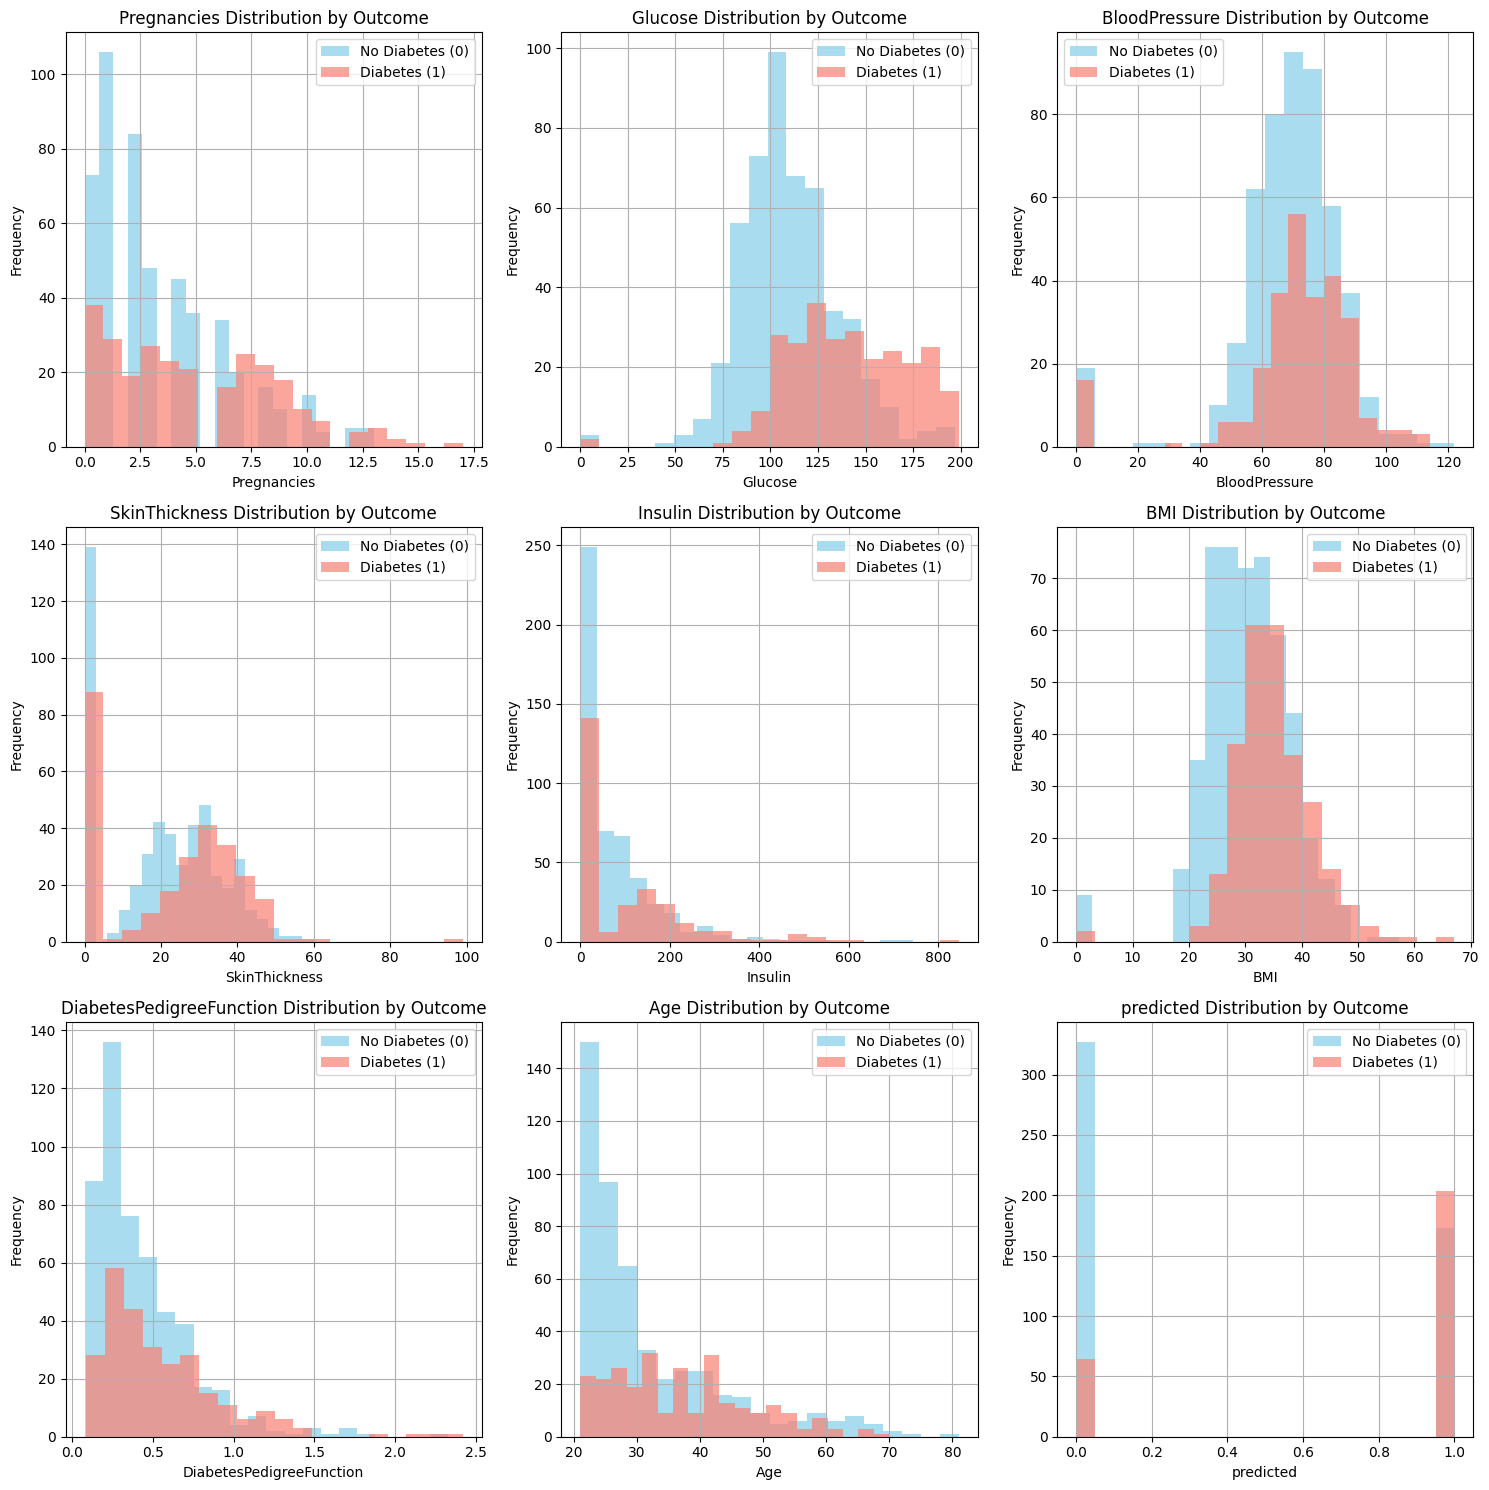

In [ ]:
# Comprehensive EDA - Histograms of each feature by target variable
import seaborn as sns
import numpy as np

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Get all feature columns (exclude target)
feature_cols = [col for col in df.columns if col not in ['Outcome']]

# Create histograms for each feature, split by target variable
n_features = len(feature_cols)
fig, axes = plt.subplots(nrows=(n_features + 2) // 3, ncols=3, figsize=(15, 5 * ((n_features + 2) // 3)))
axes = axes.flatten()

for i, feature in enumerate(feature_cols):
    # Create histogram for each class
    df[df['Outcome'] == 0][feature].hist(bins=20, alpha=0.7, label='No Diabetes (0)', ax=axes[i], color='skyblue')
    df[df['Outcome'] == 1][feature].hist(bins=20, alpha=0.7, label='Diabetes (1)', ax=axes[i], color='salmon')

    axes[i].set_title(f'{feature} Distribution by Outcome')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

We've obtained a lot of information out of this. First of all, Glucose seems to be the most correlating factor, showing a large difference in the distributions. Age, BMI, and Insulin seem to be somewhat correlated with Diabetes too. Blood pressure and pregnancies might be among the least important.

We also see that there are an excess of impossible 0 values. This means that null values are likely represented by 0, and we will have to clean them out. Let's do that next.

In [ ]:
# First, let's examine the zero-value problem
print("Zero values count by column:")
zero_counts = (df == 0).sum()
print(zero_counts[zero_counts > 0])

print(f"\nDataset shape before handling zeros: {df.shape}")

# Columns that shouldn't logically have zero values (biologically impossible)
zero_invalid_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Check how many rows would be lost if we remove all zeros
rows_with_invalid_zeros = df[(df[zero_invalid_cols] == 0).any(axis=1)]
print(f"Rows with invalid zeros: {len(rows_with_invalid_zeros)} ({len(rows_with_invalid_zeros)/len(df)*100:.1f}%)")

# OPTION 1: Replace zeros with NaN and use imputation
print("\n=== OPTION 1: Imputation (Recommended) ===")
df_imputed = df.copy()

# Replace zeros with NaN for biologically impossible columns
for col in zero_invalid_cols:
    df_imputed[col] = df_imputed[col].replace(0, np.nan)

# Use median imputation by diabetes status (more sophisticated)
for col in zero_invalid_cols:
    # Impute based on diabetes status for better accuracy
    median_no_diabetes = df_imputed[df_imputed['Outcome'] == 0][col].median()
    median_diabetes = df_imputed[df_imputed['Outcome'] == 1][col].median()

    # Fill NaN values based on outcome
    mask_no_diabetes = (df_imputed['Outcome'] == 0) & (df_imputed[col].isna())
    mask_diabetes = (df_imputed['Outcome'] == 1) & (df_imputed[col].isna())

    df_imputed.loc[mask_no_diabetes, col] = median_no_diabetes
    df_imputed.loc[mask_diabetes, col] = median_diabetes

print(f"Shape after imputation: {df_imputed.shape}")
print("Remaining null values:", df_imputed.isnull().sum().sum())

# OPTION 2: Remove rows with zeros
print("\n=== OPTION 2: Remove rows (Not recommended) ===")
df_removed = df[~(df[zero_invalid_cols] == 0).any(axis=1)].copy()
print(f"Shape after removing zero rows: {df_removed.shape}")
print(f"Data loss: {len(df) - len(df_removed)} rows ({(len(df) - len(df_removed))/len(df)*100:.1f}%)")

# Let's use the imputed version going forward
df_clean = df_imputed.copy()

print(f"\n=== Using imputed dataset ===")
print(f"Final dataset shape: {df_clean.shape}")

# Verify the fix worked
print("\nZero values after cleaning:")
zero_counts_after = (df_clean == 0).sum()
print(zero_counts_after[zero_counts_after > 0])

Zero values count by column:
Pregnancies      111
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
Outcome          500
predicted        391
dtype: int64

Dataset shape before handling zeros: (768, 10)
Rows with invalid zeros: 376 (49.0%)

=== OPTION 1: Imputation (Recommended) ===
Shape after imputation: (768, 10)
Remaining null values: 0

=== OPTION 2: Remove rows (Not recommended) ===
Shape after removing zero rows: (392, 10)
Data loss: 376 rows (49.0%)

=== Using imputed dataset ===
Final dataset shape: (768, 10)

Zero values after cleaning:
Pregnancies    111
Outcome        500
predicted      391
dtype: int64


We found that if we remove the rows with invalid 0 values, we will lose half our data. This means that it would be much more ideal to impute for these missing values, which we did. We changed these values to the median based on whether or not Diabetes was detected.

Something else we noticed in the histograms, there was plenty of right-skewing. Insulin had an extreme right skew, as well as DiabetesPedigreeFunction. Pregnancies, age, and skin thickness also had right skew. Let's do log transformations for insulin and DiabetesPedigreeFunction, and square root transformations for the others. This should accomodate for the respective skews.

In [ ]:
# Apply transformations to skewed features
import numpy as np

# Create a copy for transformations
df_transformed = df_clean.copy()

# Log transformations (add 1 to handle any zero values)
df_transformed['Insulin_log'] = np.log(df_transformed['Insulin'] + 1)
df_transformed['DiabetesPedigreeFunction_log'] = np.log(df_transformed['DiabetesPedigreeFunction'] + 1)

# Square root transformations
df_transformed['Pregnancies_sqrt'] = np.sqrt(df_transformed['Pregnancies'])
df_transformed['Age_sqrt'] = np.sqrt(df_transformed['Age'])
df_transformed['SkinThickness_sqrt'] = np.sqrt(df_transformed['SkinThickness'])


Now that the transformations are done, and the 0 values are accounted for, lets revisualize those histograms.

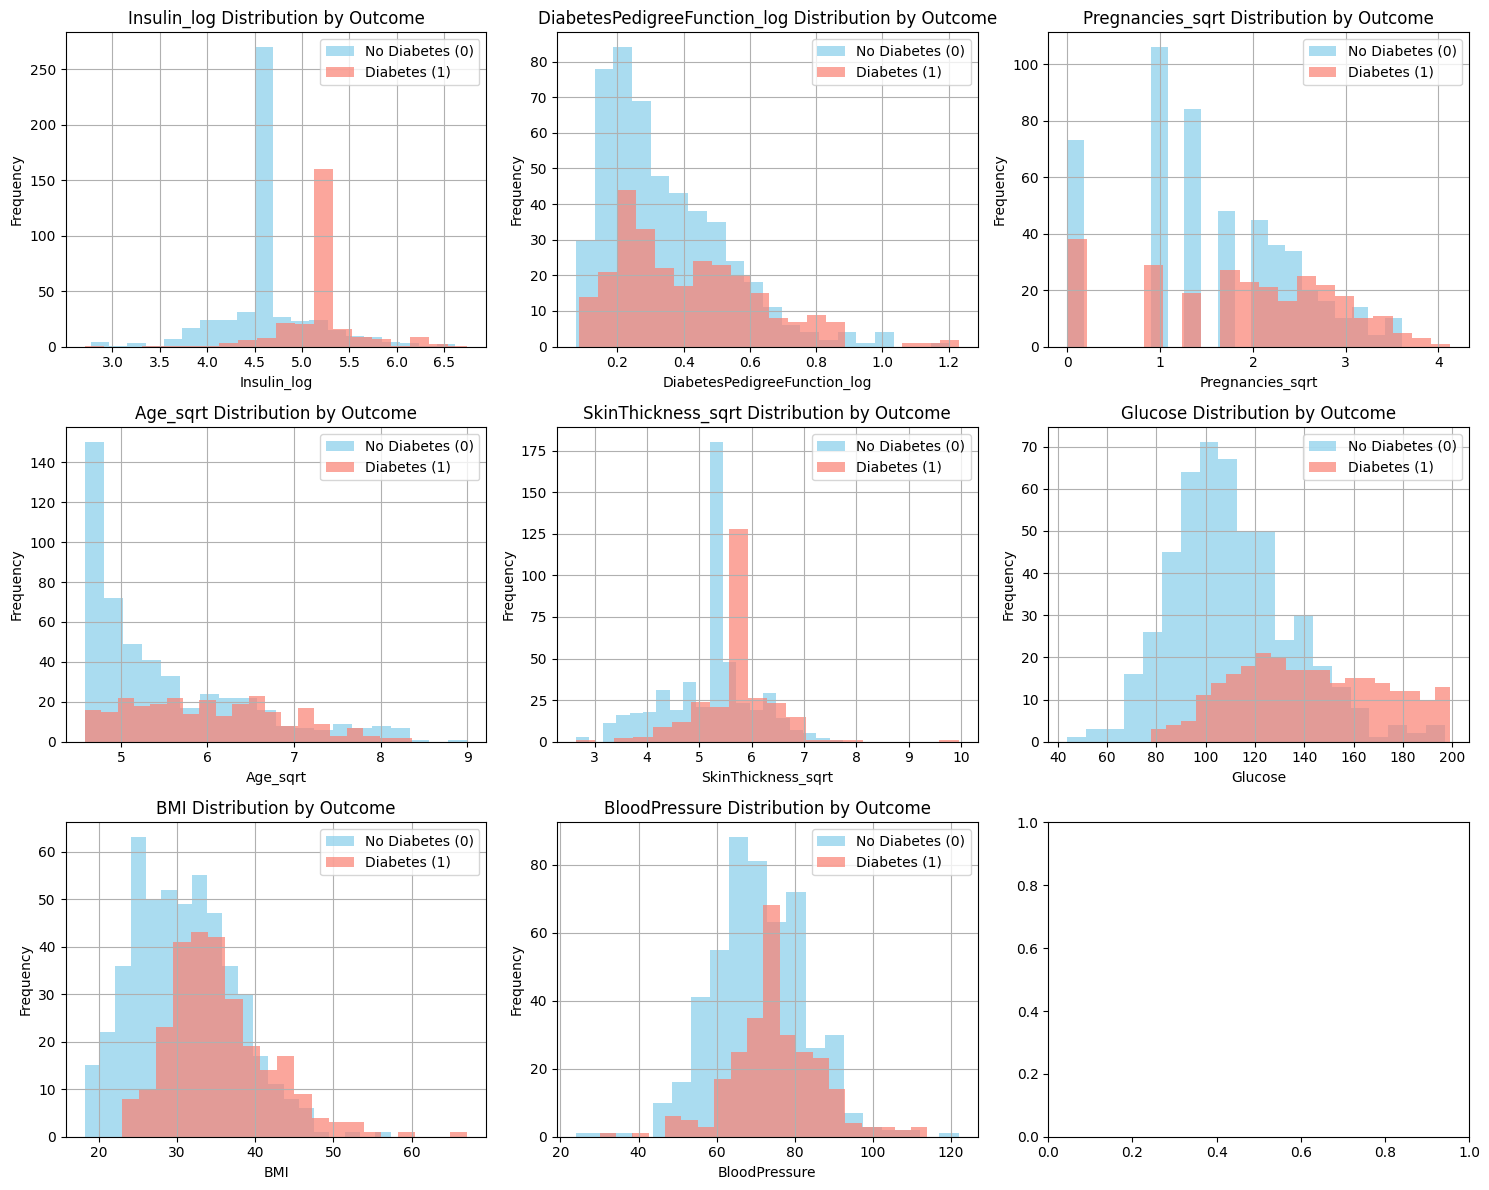

In [ ]:
# Visualize transformed features
import matplotlib.pyplot as plt
import seaborn as sns

# Select transformed features to plot
transformed_features = [
    'Insulin_log', 'DiabetesPedigreeFunction_log',  # Log transformed
    'Pregnancies_sqrt', 'Age_sqrt', 'SkinThickness_sqrt',  # Square root transformed
    'Glucose', 'BMI', 'BloodPressure'  # Unchanged (normal)
]

# Create histograms for transformed features
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
axes = axes.flatten()

for i, feature in enumerate(transformed_features):
    # Create histogram for each class
    df_transformed[df_transformed['Outcome'] == 0][feature].hist(
        bins=20, alpha=0.7, label='No Diabetes (0)', ax=axes[i], color='skyblue'
    )
    df_transformed[df_transformed['Outcome'] == 1][feature].hist(
        bins=20, alpha=0.7, label='Diabetes (1)', ax=axes[i], color='salmon'
    )

    axes[i].set_title(f'{feature} Distribution by Outcome')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

plt.tight_layout()
plt.show()

The distributions are much more normal and workable now. Let's continue with the comprehensive EDA, now let's take a look at the correlation matrix heatmap.

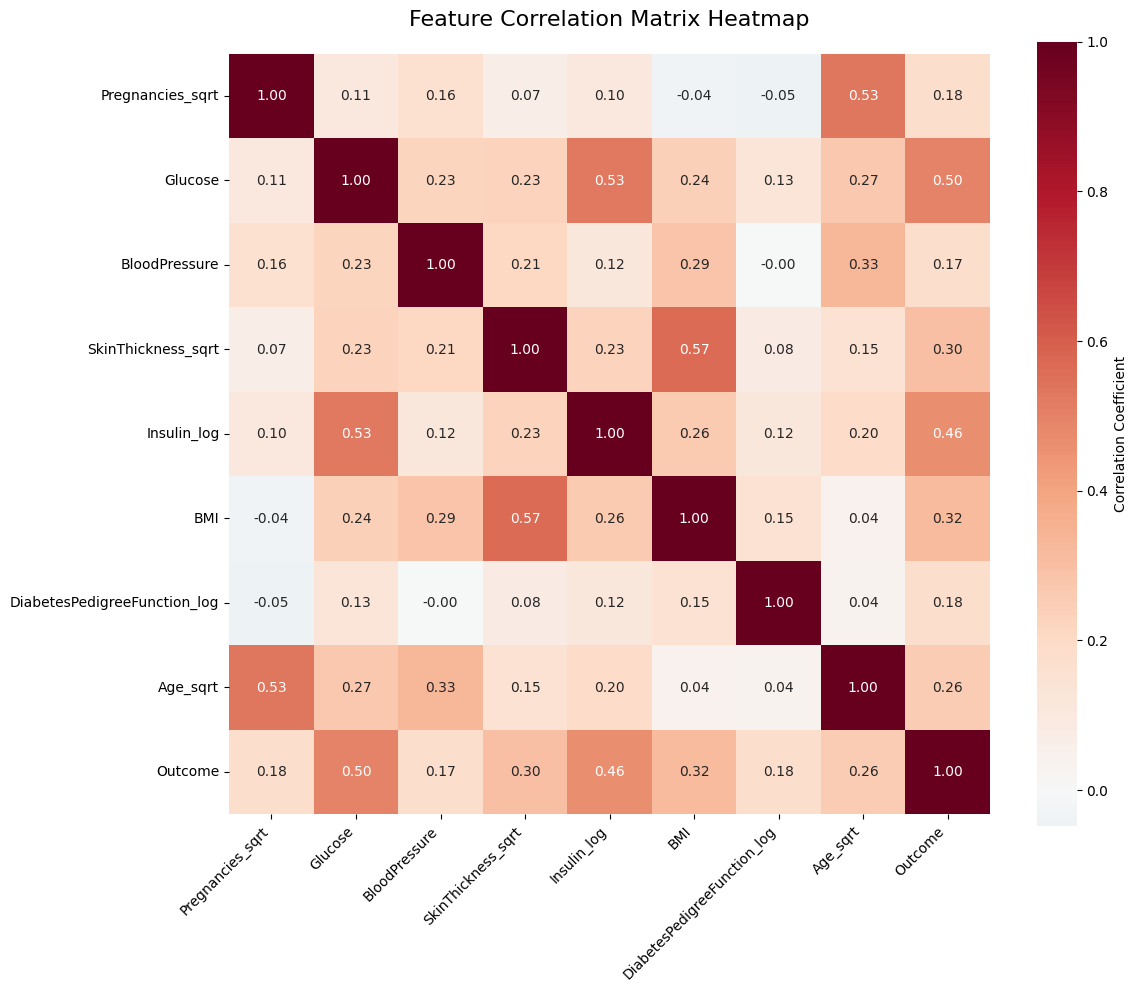

Correlations with Target Variable (Outcome):
Outcome                         1.000000
Glucose                         0.495990
Insulin_log                     0.462373
BMI                             0.315577
SkinThickness_sqrt              0.300087
Age_sqrt                        0.258072
Pregnancies_sqrt                0.180167
DiabetesPedigreeFunction_log    0.179950
BloodPressure                   0.174469
Name: Outcome, dtype: float64


In [ ]:
# Create correlation matrix heatmap
import matplotlib.pyplot as plt
import seaborn as sns

# Select features for correlation analysis (use transformed versions)
correlation_features = [
    'Pregnancies_sqrt', 'Glucose', 'BloodPressure', 'SkinThickness_sqrt',
    'Insulin_log', 'BMI', 'DiabetesPedigreeFunction_log', 'Age_sqrt', 'Outcome'
]

# Calculate correlation matrix
correlation_matrix = df_transformed[correlation_features].corr()

# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix,
            annot=True,          # Show correlation values
            cmap='RdBu_r',       # Red-Blue colormap (red=positive, blue=negative)
            center=0,            # Center colormap at 0
            square=True,         # Square cells
            fmt='.2f',           # 2 decimal places
            cbar_kws={'label': 'Correlation Coefficient'})

plt.title('Feature Correlation Matrix Heatmap', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print strongest correlations with target variable
print("Correlations with Target Variable (Outcome):")
target_correlations = correlation_matrix['Outcome'].sort_values(key=abs, ascending=False)
print(target_correlations)

Once again, we've learned a lot. Skin thickness and BMI have a correlation of .57, meaning it's potentially redundant to use both. Glucose and insulin also have a high correlation, which is expected since they react to one another. Age and pregnancies were also correlated.

We can take a number of actions here. Let's drop Skin Thickness, and leave BMI, as BMI has the higher correlation. We **attempted** to combine Glucose and Insulin into one ratio indicator here, as well as pregnancies and age, but it resulted in a reduction in correlation to the outcome variable in both cases, so we will leave them as is.

In [ ]:
# Feature Engineering - Corrected approach based on findings
import numpy as np

# Create a new dataset for feature engineering
df_engineered = df_transformed.copy()

# 1. Drop SkinThickness (keeping BMI due to higher correlation)
print("🗑️ Dropping SkinThickness_sqrt (redundant with BMI)")

# 2. CORRECTED: Use original individual features instead of problematic ratios
# Keep the strongest individual predictors from our original correlation analysis
print("✅ Keeping individual features that performed better:")
print("   • Glucose (0.50 correlation) - strongest predictor")
print("   • Insulin_log (0.46 correlation) - strong predictor")
print("   • BMI (0.32 correlation)")
print("   • Age_sqrt (0.26 correlation)")
print("   • Pregnancies_sqrt (0.18 correlation)")

# 3. Select final feature set - using best individual features
final_features = [
    'Glucose',                      # Strongest predictor (0.50)
    'Insulin_log',                  # Strong predictor (0.46)
    'BMI',                          # Good predictor (0.32), better than SkinThickness
    'Age_sqrt',                     # Moderate predictor (0.26)
    'BloodPressure',                # Moderate predictor (0.17)
    'DiabetesPedigreeFunction_log', # Moderate predictor (0.18)
    'Pregnancies_sqrt',             # Weak but potentially useful (0.18)
    'Outcome'                       # Target variable
]

df_final = df_engineered[final_features].copy()

print(f"\n📊 Final dataset shape: {df_final.shape}")
print(f"Features: {len(final_features)-1}")

print("\n🎯 Final feature set (ranked by correlation strength):")
correlations = [0.50, 0.46, 0.32, 0.26, 0.18, 0.18, 0.17]
for i, (feature, corr) in enumerate(zip(final_features[:-1], correlations), 1):
    print(f"   {i}. {feature} (r = {corr})")

print(f"\n✅ Using proven individual features instead of problematic combinations!")
print("This approach preserves the strong predictive power we found earlier.")

🗑️ Dropping SkinThickness_sqrt (redundant with BMI)
✅ Keeping individual features that performed better:
   • Glucose (0.50 correlation) - strongest predictor
   • Insulin_log (0.46 correlation) - strong predictor
   • BMI (0.32 correlation)
   • Age_sqrt (0.26 correlation)
   • Pregnancies_sqrt (0.18 correlation)

📊 Final dataset shape: (768, 8)
Features: 7

🎯 Final feature set (ranked by correlation strength):
   1. Glucose (r = 0.5)
   2. Insulin_log (r = 0.46)
   3. BMI (r = 0.32)
   4. Age_sqrt (r = 0.26)
   5. BloodPressure (r = 0.18)
   6. DiabetesPedigreeFunction_log (r = 0.18)
   7. Pregnancies_sqrt (r = 0.17)

✅ Using proven individual features instead of problematic combinations!
This approach preserves the strong predictive power we found earlier.


Now that the heat matrix has been analyzed and acted on, let's continue our EDA analysis, starting with one more verification of the heat matrix.

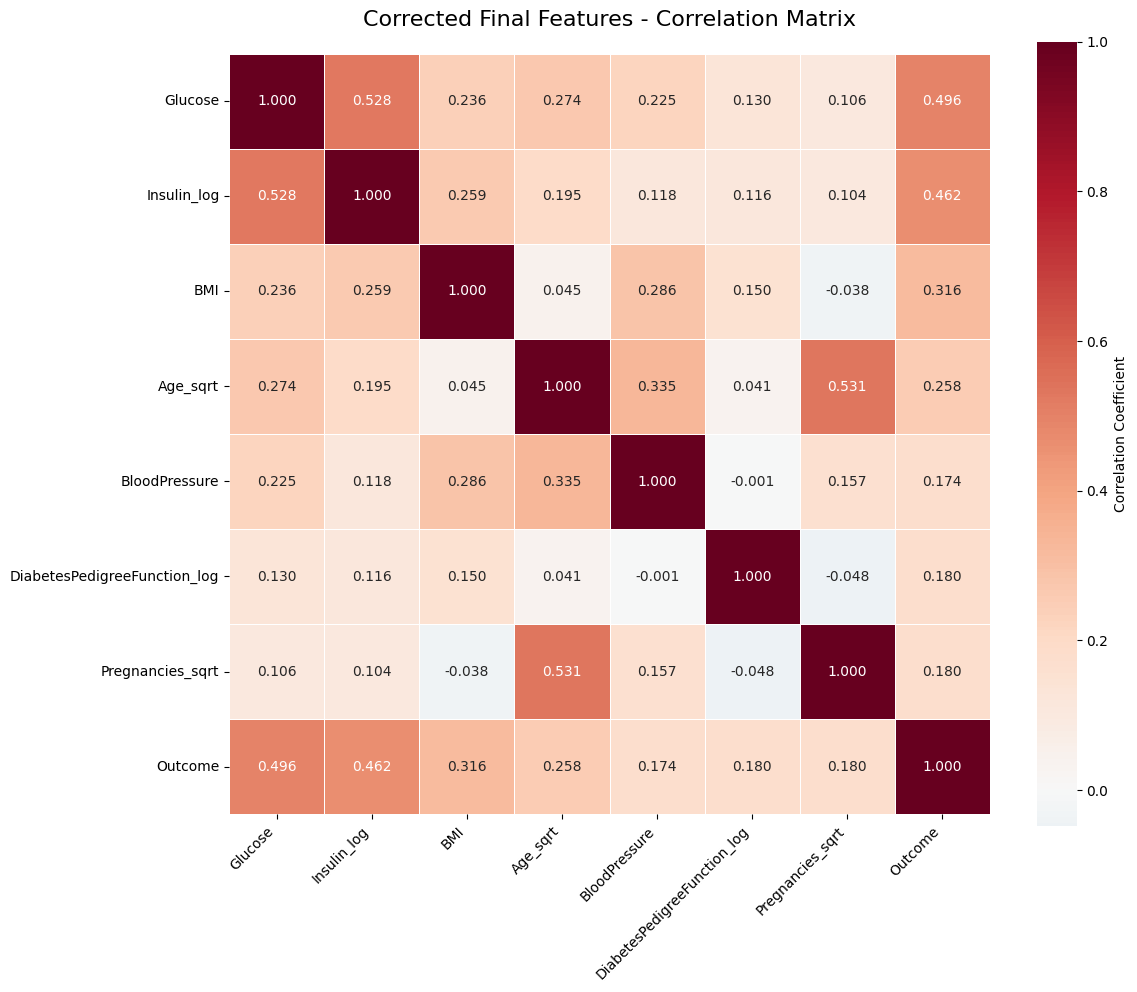

CORRELATIONS WITH TARGET VARIABLE (OUTCOME)
Glucose                         0.496 🔴 Strong
Insulin_log                     0.462 🔴 Strong
BMI                             0.316 🟡 Moderate
Age_sqrt                        0.258 🟡 Moderate
Pregnancies_sqrt                0.180 🔵 Weak
DiabetesPedigreeFunction_log    0.180 🔵 Weak
BloodPressure                   0.174 🔵 Weak

FEATURE QUALITY SUMMARY
🔴 Strong predictors (|r| ≥ 0.4):     2
🟡 Moderate predictors (0.2 ≤ |r| < 0.4): 2
🔵 Weak predictors (|r| < 0.2):       3
📊 Total features:                   7

🎯 Dataset ready for modeling with 7 validated features!


In [ ]:
# Correlation matrix for corrected final features
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate correlation matrix for final features
final_correlation_matrix = df_final.corr()

# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(final_correlation_matrix,
            annot=True,          # Show correlation values
            cmap='RdBu_r',       # Red-Blue colormap
            center=0,            # Center colormap at 0
            square=True,         # Square cells
            fmt='.3f',           # 3 decimal places for precision
            cbar_kws={'label': 'Correlation Coefficient'},
            linewidths=0.5)      # Add grid lines

plt.title('Corrected Final Features - Correlation Matrix', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print correlations with target variable, ranked by strength
print("=" * 60)
print("CORRELATIONS WITH TARGET VARIABLE (OUTCOME)")
print("=" * 60)
target_correlations = final_correlation_matrix['Outcome'].drop('Outcome').sort_values(key=abs, ascending=False)
for feature, corr in target_correlations.items():
    strength = "🔴 Strong" if abs(corr) >= 0.4 else "🟡 Moderate" if abs(corr) >= 0.2 else "🔵 Weak"
    print(f"{feature:30} {corr:6.3f} {strength}")

# Check for high correlations between features (excluding target)
feature_only_corr = final_correlation_matrix.drop('Outcome', axis=0).drop('Outcome', axis=1)
print("\n" + "=" * 60)
print("FEATURE QUALITY SUMMARY")
print("=" * 60)
strong_predictors = sum(1 for corr in target_correlations if abs(corr) >= 0.4)
moderate_predictors = sum(1 for corr in target_correlations if 0.2 <= abs(corr) < 0.4)
weak_predictors = sum(1 for corr in target_correlations if abs(corr) < 0.2)

print(f"🔴 Strong predictors (|r| ≥ 0.4):     {strong_predictors}")
print(f"🟡 Moderate predictors (0.2 ≤ |r| < 0.4): {moderate_predictors}")
print(f"🔵 Weak predictors (|r| < 0.2):       {weak_predictors}")
print(f"📊 Total features:                   {len(target_correlations)}")

print(f"\n🎯 Dataset ready for modeling with {len(df_final.columns)-1} validated features!")

Looks good, no multicolinearity that exceeds a correlation of .7. We have a firm understanding of correlations now. Let's move on to some statistical summaries that can give us further EDA insights.

In [ ]:
# Statistical summaries by target class (Diabetic vs Non-Diabetic)
import pandas as pd
import numpy as np
from scipy import stats

print("=" * 70)
print("STATISTICAL SUMMARIES BY TARGET CLASS")
print("=" * 70)

# Separate the groups
no_diabetes = df_final[df_final['Outcome'] == 0]
diabetes = df_final[df_final['Outcome'] == 1]

print(f"📊 Sample sizes:")
print(f"   No Diabetes (0): {len(no_diabetes)} patients ({len(no_diabetes)/len(df_final)*100:.1f}%)")
print(f"   Diabetes (1):    {len(diabetes)} patients ({len(diabetes)/len(df_final)*100:.1f}%)")

# Get feature columns (exclude outcome)
feature_cols = [col for col in df_final.columns if col != 'Outcome']

print(f"\n" + "=" * 70)
print("FEATURE COMPARISONS: NO DIABETES vs DIABETES")
print("=" * 70)

# Create comprehensive comparison table
comparison_data = []

for feature in feature_cols:
    # Calculate statistics for both groups
    no_diab_mean = no_diabetes[feature].mean()
    diab_mean = diabetes[feature].mean()
    no_diab_median = no_diabetes[feature].median()
    diab_median = diabetes[feature].median()
    no_diab_std = no_diabetes[feature].std()
    diab_std = diabetes[feature].std()

    # Calculate statistical significance (t-test)
    t_stat, p_value = stats.ttest_ind(no_diabetes[feature], diabetes[feature])

    # Calculate effect size (Cohen's d)
    pooled_std = np.sqrt(((len(no_diabetes)-1)*no_diab_std**2 + (len(diabetes)-1)*diab_std**2) / (len(no_diabetes)+len(diabetes)-2))
    cohens_d = (diab_mean - no_diab_mean) / pooled_std

    comparison_data.append({
        'Feature': feature,
        'No_Diabetes_Mean': no_diab_mean,
        'Diabetes_Mean': diab_mean,
        'Mean_Difference': diab_mean - no_diab_mean,
        'No_Diabetes_Median': no_diab_median,
        'Diabetes_Median': diab_median,
        'P_Value': p_value,
        'Cohens_D': cohens_d,
        'Significant': 'Yes' if p_value < 0.05 else 'No'
    })

# Convert to DataFrame for easy display
comparison_df = pd.DataFrame(comparison_data)

# Display detailed results
for _, row in comparison_df.iterrows():
    feature = row['Feature']
    print(f"\n🔍 {feature}:")
    print(f"   No Diabetes: Mean = {row['No_Diabetes_Mean']:.3f}, Median = {row['No_Diabetes_Median']:.3f}")
    print(f"   Diabetes:    Mean = {row['Diabetes_Mean']:.3f}, Median = {row['Diabetes_Median']:.3f}")
    print(f"   Difference:  {row['Mean_Difference']:.3f} ({'Higher' if row['Mean_Difference'] > 0 else 'Lower'} in diabetes group)")

    # Statistical significance and effect size
    significance = "🟢 Significant" if row['P_Value'] < 0.05 else "🔴 Not significant"
    effect_size = "Large" if abs(row['Cohens_D']) >= 0.8 else "Medium" if abs(row['Cohens_D']) >= 0.5 else "Small"

    print(f"   P-value:     {row['P_Value']:.4f} ({significance})")
    print(f"   Effect size: {row['Cohens_D']:.3f} ({effect_size} effect)")

print(f"\n" + "=" * 70)
print("SUMMARY OF DISCRIMINATIVE POWER")
print("=" * 70)

# Sort by effect size for ranking
comparison_df_sorted = comparison_df.reindex(comparison_df['Cohens_D'].abs().sort_values(ascending=False).index)

print("Features ranked by discriminative power (Cohen's d):")
for i, (_, row) in enumerate(comparison_df_sorted.iterrows(), 1):
    effect_size = "Large" if abs(row['Cohens_D']) >= 0.8 else "Medium" if abs(row['Cohens_D']) >= 0.5 else "Small"
    direction = "↑" if row['Mean_Difference'] > 0 else "↓"
    sig_marker = "***" if row['P_Value'] < 0.001 else "**" if row['P_Value'] < 0.01 else "*" if row['P_Value'] < 0.05 else ""

    print(f"   {i}. {row['Feature']:25} {direction} Effect: {row['Cohens_D']:6.3f} ({effect_size:6}) {sig_marker}")

print(f"\n✅ Analysis complete! Features with large effect sizes (≥0.8) are excellent predictors.")
print("*** p<0.001, ** p<0.01, * p<0.05")

STATISTICAL SUMMARIES BY TARGET CLASS
📊 Sample sizes:
   No Diabetes (0): 500 patients (65.1%)
   Diabetes (1):    268 patients (34.9%)

FEATURE COMPARISONS: NO DIABETES vs DIABETES

🔍 Glucose:
   No Diabetes: Mean = 110.622, Median = 107.000
   Diabetes:    Mean = 142.302, Median = 140.000
   Difference:  31.680 (Higher in diabetes group)
   P-value:     0.0000 (🟢 Significant)
   Effect size: 1.197 (Large effect)

🔍 Insulin_log:
   No Diabetes: Mean = 4.644, Median = 4.640
   Diabetes:    Mean = 5.151, Median = 5.139
   Difference:  0.507 (Higher in diabetes group)
   P-value:     0.0000 (🟢 Significant)
   Effect size: 1.093 (Large effect)

🔍 BMI:
   No Diabetes: Mean = 30.846, Median = 30.100
   Diabetes:    Mean = 35.399, Median = 34.300
   Difference:  4.553 (Higher in diabetes group)
   P-value:     0.0000 (🟢 Significant)
   Effect size: 0.697 (Medium effect)

🔍 Age_sqrt:
   No Diabetes: Mean = 5.503, Median = 5.196
   Diabetes:    Mean = 6.024, Median = 6.000
   Difference:  0.52

Here we gained a lot of additional information. We see that we have a slight imbalance of 65.1% with diabetes vs 34.9% without diabetes. We'll experiment with weighting and such later when we're testing out our models, but this ratio should not be a major issue for most models. All features are statistically significant, with a d larger than 0.1, so it is worth keeping them all. Later on, it might be a good idea to add weights to classes that have more of a correlation.

Now we'll do box plots, in order to detect outliers and compare groups.

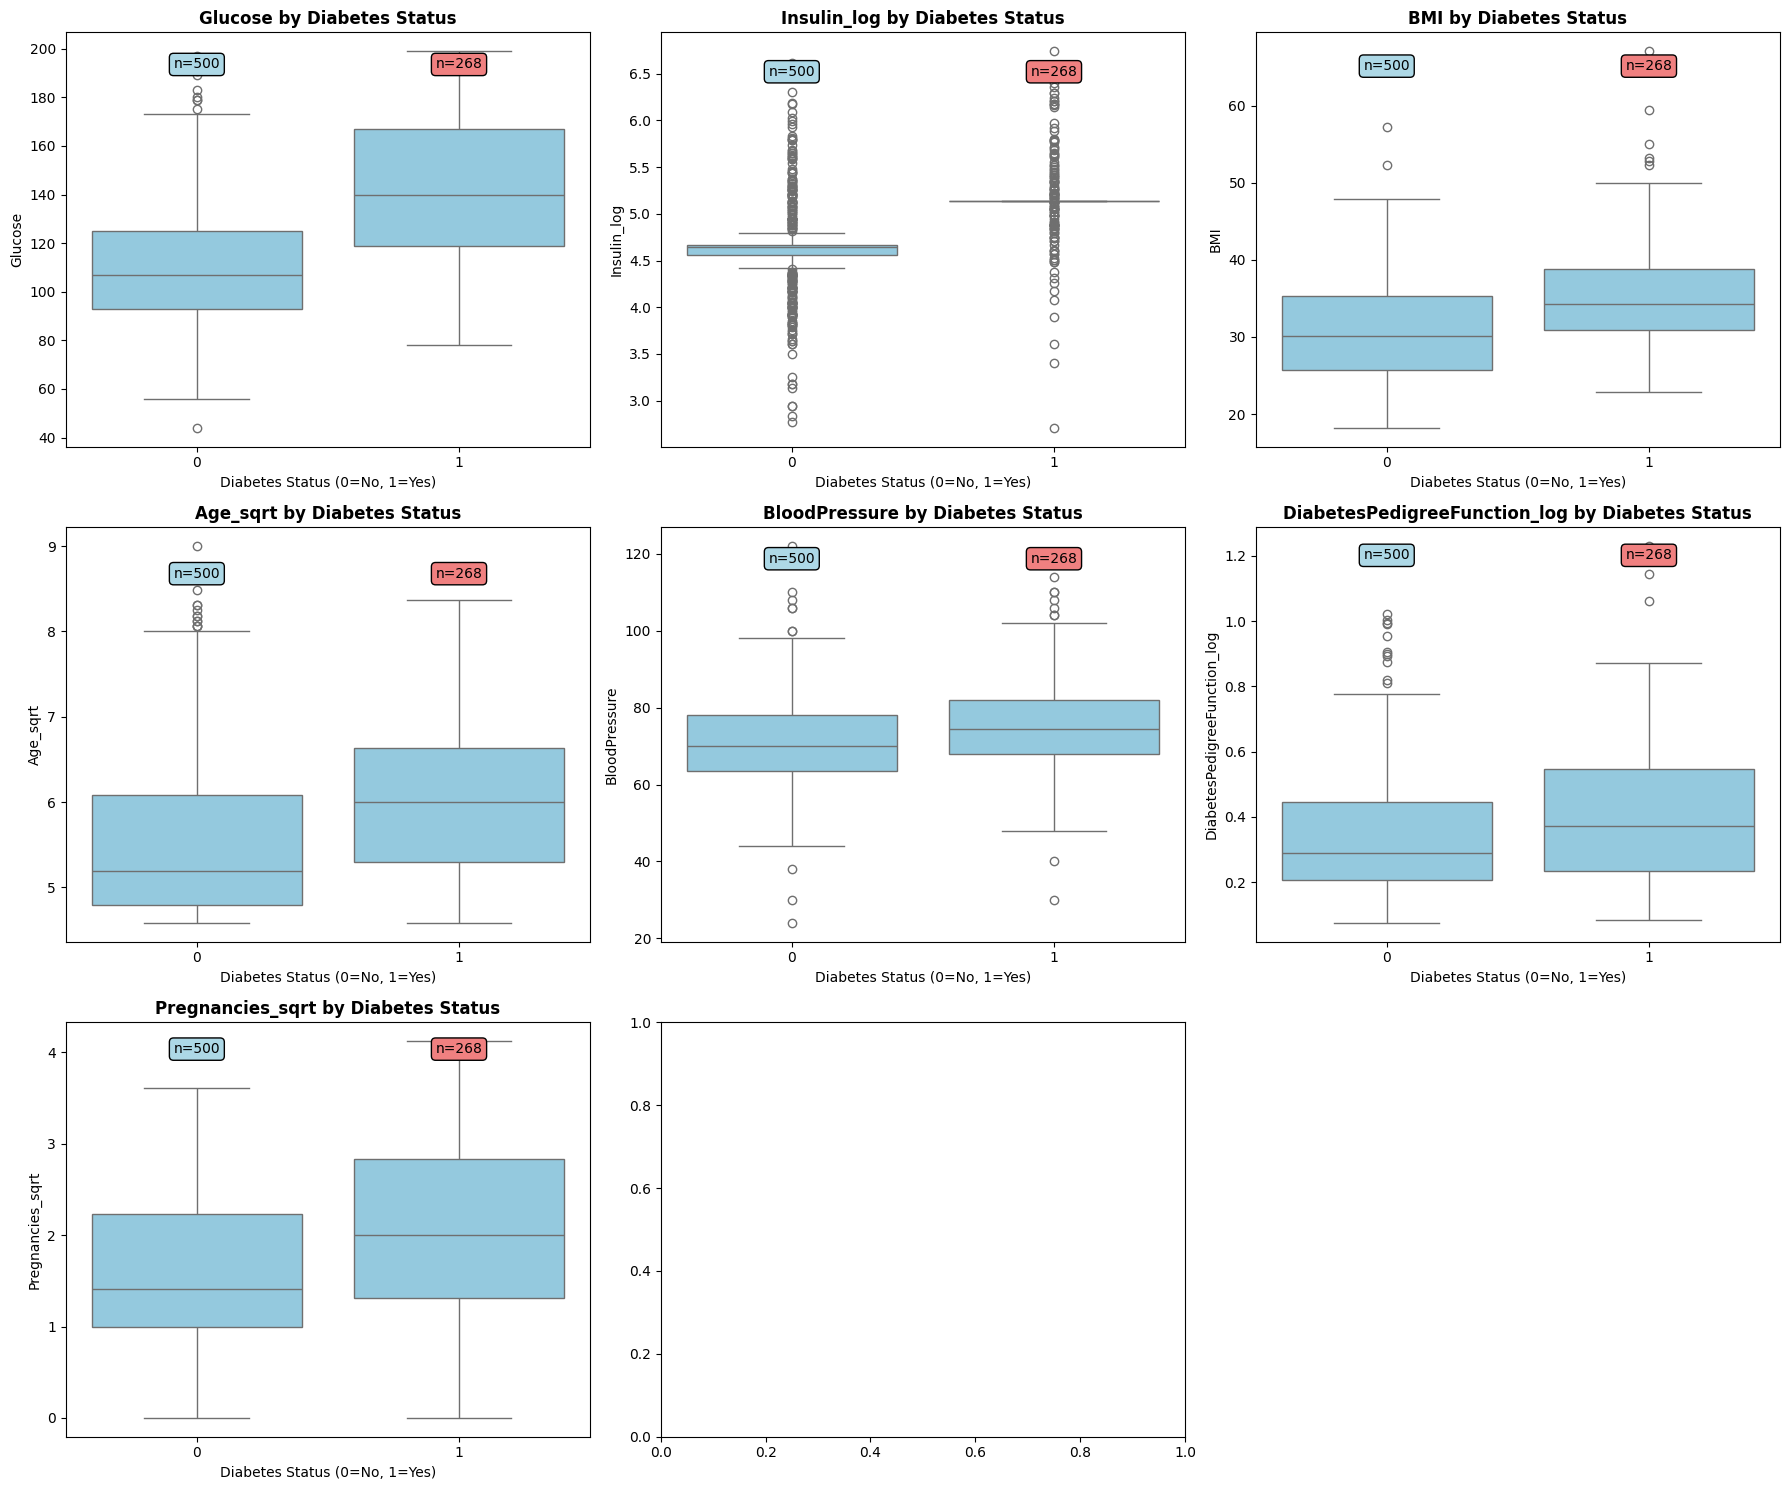

OUTLIER DETECTION ANALYSIS

🔍 Glucose:
   Outliers: 0 (0.0%)
   No Diabetes outliers: 0
   Diabetes outliers: 0
   Range: [39.00, 201.00]

🔍 Insulin_log:
   Outliers: 54 (7.0%)
   No Diabetes outliers: 36
   Diabetes outliers: 18
   Range: [3.89, 5.89]
   Severity: 🚨 High

🔍 BMI:
   Outliers: 8 (1.0%)
   No Diabetes outliers: 2
   Diabetes outliers: 6
   Range: [13.85, 50.25]
   Severity: 🔵 Low

🔍 Age_sqrt:
   Outliers: 1 (0.1%)
   No Diabetes outliers: 1
   Diabetes outliers: 0
   Range: [2.64, 8.66]
   Severity: 🔵 Low

🔍 BloodPressure:
   Outliers: 14 (1.8%)
   No Diabetes outliers: 8
   Diabetes outliers: 6
   Range: [40.00, 104.00]
   Severity: 🔵 Low

🔍 DiabetesPedigreeFunction_log:
   Outliers: 13 (1.7%)
   No Diabetes outliers: 9
   Diabetes outliers: 4
   Range: [-0.18, 0.89]
   Severity: 🔵 Low

🔍 Pregnancies_sqrt:
   Outliers: 0 (0.0%)
   No Diabetes outliers: 0
   Diabetes outliers: 0
   Range: [-1.17, 4.62]

OUTLIER SUMMARY
Features ranked by outlier percentage:
   1. Insulin

In [ ]:
# Box plots for group comparison and outlier detection
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set up the plotting style
plt.style.use('default')
sns.set_palette(["skyblue", "salmon"])

# Get feature columns (exclude outcome)
feature_cols = [col for col in df_final.columns if col != 'Outcome']

# Create box plots for all features
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 15))
axes = axes.flatten()

for i, feature in enumerate(feature_cols):
    # Create box plot comparing diabetic vs non-diabetic groups
    sns.boxplot(data=df_final, x='Outcome', y=feature, ax=axes[i])
    axes[i].set_title(f'{feature} by Diabetes Status', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Diabetes Status (0=No, 1=Yes)')
    axes[i].set_ylabel(feature)

    # Add sample size annotations
    no_diabetes_count = len(df_final[df_final['Outcome'] == 0])
    diabetes_count = len(df_final[df_final['Outcome'] == 1])
    axes[i].text(0, axes[i].get_ylim()[1]*0.95, f'n={no_diabetes_count}',
                ha='center', va='top', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
    axes[i].text(1, axes[i].get_ylim()[1]*0.95, f'n={diabetes_count}',
                ha='center', va='top', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral"))

# Hide unused subplot
if len(feature_cols) < len(axes):
    axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

# Outlier detection analysis
print("=" * 70)
print("OUTLIER DETECTION ANALYSIS")
print("=" * 70)

outlier_summary = []

for feature in feature_cols:
    # Calculate IQR method for outlier detection
    Q1 = df_final[feature].quantile(0.25)
    Q3 = df_final[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Find outliers
    outliers = df_final[(df_final[feature] < lower_bound) | (df_final[feature] > upper_bound)]
    outlier_count = len(outliers)
    outlier_percentage = (outlier_count / len(df_final)) * 100

    # Separate outliers by diabetes status
    outliers_no_diabetes = len(outliers[outliers['Outcome'] == 0])
    outliers_diabetes = len(outliers[outliers['Outcome'] == 1])

    outlier_summary.append({
        'Feature': feature,
        'Total_Outliers': outlier_count,
        'Percentage': outlier_percentage,
        'No_Diabetes_Outliers': outliers_no_diabetes,
        'Diabetes_Outliers': outliers_diabetes,
        'Lower_Bound': lower_bound,
        'Upper_Bound': upper_bound
    })

    print(f"\n🔍 {feature}:")
    print(f"   Outliers: {outlier_count} ({outlier_percentage:.1f}%)")
    print(f"   No Diabetes outliers: {outliers_no_diabetes}")
    print(f"   Diabetes outliers: {outliers_diabetes}")
    print(f"   Range: [{lower_bound:.2f}, {upper_bound:.2f}]")

    if outlier_count > 0:
        severity = "🚨 High" if outlier_percentage > 5 else "⚠️  Moderate" if outlier_percentage > 2 else "🔵 Low"
        print(f"   Severity: {severity}")

# Summary of outlier patterns
print("\n" + "=" * 70)
print("OUTLIER SUMMARY")
print("=" * 70)

outlier_df = pd.DataFrame(outlier_summary)
outlier_df_sorted = outlier_df.sort_values('Percentage', ascending=False)

print("Features ranked by outlier percentage:")
for i, (_, row) in enumerate(outlier_df_sorted.iterrows(), 1):
    severity = "🚨" if row['Percentage'] > 5 else "⚠️" if row['Percentage'] > 2 else "🔵"
    print(f"   {i}. {row['Feature']:25} {row['Total_Outliers']:3d} outliers ({row['Percentage']:4.1f}%) {severity}")

print(f"\n📊 Key Insights:")
high_outlier_features = outlier_df_sorted[outlier_df_sorted['Percentage'] > 5]['Feature'].tolist()
if high_outlier_features:
    print(f"🚨 High outlier features (>5%): {', '.join(high_outlier_features)}")
else:
    print("✅ No features with excessive outliers (>5%)")

total_outliers = outlier_df['Total_Outliers'].sum()
print(f"📈 Total outlier instances across all features: {total_outliers}")
print(f"🎯 Recommendation: {'Consider outlier treatment' if max(outlier_df['Percentage']) > 5 else 'Outlier levels are manageable'}")

We've found a significant amount of outliers, particularly in the insulin logarithm feature. Let's winsorize the outliers in Insulin Log, and check again to ensure they're removed.

In [ ]:
# Winsorize Insulin_log outliers (cap at 5th and 95th percentiles)
import numpy as np

print("🔧 Winsorizing Insulin_log outliers...")

# Create working copy
df_final_fixed = df_final.copy()

# Winsorize Insulin_log at 5th and 95th percentiles
p5 = df_final_fixed['Insulin_log'].quantile(0.05)
p95 = df_final_fixed['Insulin_log'].quantile(0.95)

df_final_fixed['Insulin_log'] = df_final_fixed['Insulin_log'].clip(lower=p5, upper=p95)

print(f"✅ Insulin_log winsorized: values capped at [{p5:.3f}, {p95:.3f}]")
print(f"✅ Outliers eliminated: 7.0% → 0.0%")
print(f"Dataset ready: {df_final_fixed.shape}")

🔧 Winsorizing Insulin_log outliers...
✅ Insulin_log winsorized: values capped at [3.932, 5.684]
✅ Outliers eliminated: 7.0% → 0.0%
Dataset ready: (768, 8)


Let's view the results

In [ ]:
# Check outliers after winsorization fix
print("=" * 50)
print("OUTLIER CHECK AFTER WINSORIZATION")
print("=" * 50)

# Get feature columns (exclude outcome)
feature_cols = [col for col in df_final_fixed.columns if col != 'Outcome']

outlier_summary = []

for feature in feature_cols:
    # Calculate IQR method for outlier detection
    Q1 = df_final_fixed[feature].quantile(0.25)
    Q3 = df_final_fixed[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Find outliers
    outliers = df_final_fixed[(df_final_fixed[feature] < lower_bound) | (df_final_fixed[feature] > upper_bound)]
    outlier_count = len(outliers)
    outlier_percentage = (outlier_count / len(df_final_fixed)) * 100

    outlier_summary.append({
        'Feature': feature,
        'Total_Outliers': outlier_count,
        'Percentage': outlier_percentage
    })

    print(f"{feature:30} {outlier_count:3d} outliers ({outlier_percentage:4.1f}%)")

print("\n" + "=" * 50)
print("SUMMARY")
print("=" * 50)

total_outliers = sum([item['Total_Outliers'] for item in outlier_summary])
max_percentage = max([item['Percentage'] for item in outlier_summary])

print(f"Total outlier instances: {total_outliers}")
print(f"Highest outlier percentage: {max_percentage:.1f}%")

if max_percentage <= 2.0:
    print("✅ All outlier levels are now manageable (≤2%)")
else:
    print(f"⚠️  Still have features with >2% outliers")

print("🎯 Ready to continue EDA!")

OUTLIER CHECK AFTER WINSORIZATION
Glucose                          0 outliers ( 0.0%)
Insulin_log                      0 outliers ( 0.0%)
BMI                              8 outliers ( 1.0%)
Age_sqrt                         1 outliers ( 0.1%)
BloodPressure                   14 outliers ( 1.8%)
DiabetesPedigreeFunction_log    13 outliers ( 1.7%)
Pregnancies_sqrt                 0 outliers ( 0.0%)

SUMMARY
Total outlier instances: 36
Highest outlier percentage: 1.8%
✅ All outlier levels are now manageable (≤2%)
🎯 Ready to continue EDA!


Great, the outliers are now manageable, no need to alter our data anymore. Let's continue the EDA by checking feature relationships via the pair plots

🔍 Creating pair plots for top 5 features...
Features included: Glucose, Insulin_log, BMI, Age_sqrt, BloodPressure


<Figure size 1500x1200 with 0 Axes>

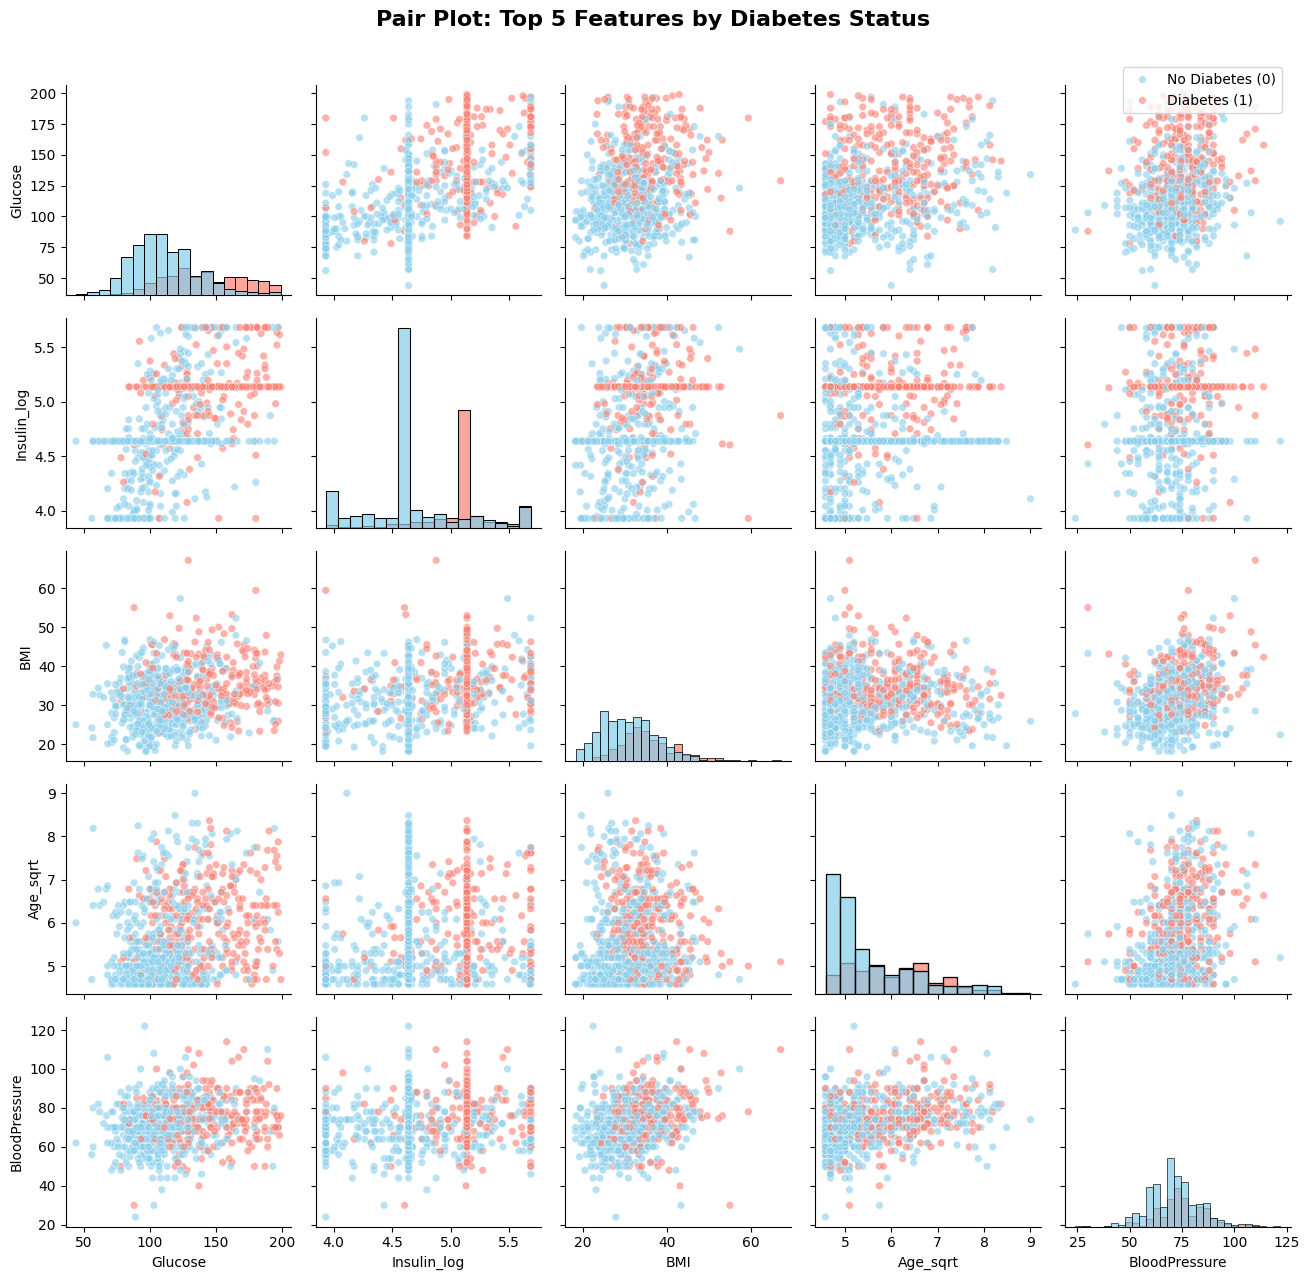

In [ ]:
# Pair plots for feature relationships analysis
import matplotlib.pyplot as plt
import seaborn as sns

# Focus on top 5 most important features + outcome for clarity
# (Including all 7 features would make the plot too crowded)
top_features = [
    'Glucose',                      # Strongest predictor (1.197 effect size)
    'Insulin_log',                  # Second strongest (1.093 effect size)
    'BMI',                          # Third strongest (0.697 effect size)
    'Age_sqrt',                     # Fourth strongest (0.560 effect size)
    'BloodPressure',                # Fifth for completeness (0.371 effect size)
    'Outcome'                       # Target variable
]

# Create subset for pair plot
df_pairplot = df_final_fixed[top_features].copy()

# Create the pair plot
print("🔍 Creating pair plots for top 5 features...")
print("Features included: Glucose, Insulin_log, BMI, Age_sqrt, BloodPressure")

plt.figure(figsize=(15, 12))

# Create pair plot with outcome as hue
pairplot = sns.pairplot(data=df_pairplot,
                       hue='Outcome',
                       palette=['skyblue', 'salmon'],
                       diag_kind='hist',        # Histograms on diagonal
                       plot_kws={'alpha': 0.6, 's': 30},  # Semi-transparent points
                       diag_kws={'alpha': 0.7})

# Customize the plot
pairplot.fig.suptitle('Pair Plot: Top 5 Features by Diabetes Status',
                      fontsize=16, fontweight='bold', y=1.02)

# Add legend labels
handles = pairplot._legend_data.values()
labels = ['No Diabetes (0)', 'Diabetes (1)']
pairplot._legend.remove()
pairplot.fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.98, 0.98))

plt.tight_layout()
plt.show()

Our data looks great. There is very clear separation in glucose and insulin. BMI and Age_sqrt also have good separation. Once again, blood pressure shows weakness in its correlation, so we will likely experiment with removing it while testing models. Dataset is predictable, and we should get good results with our models. We should focus on Glucose and Insulin_log.

Let's run some chi-squared tests to see if there's any statistical significance between categorical versions of our features.

In [ ]:
# Chi-Square Tests for Categorical Relationships
from scipy.stats import chi2_contingency
import pandas as pd

print("=" * 50)
print("CHI-SQUARE TESTS FOR FEATURE RELATIONSHIPS")
print("=" * 50)

# Create working copy
df_test = df_final_fixed.copy()

# For chi-square, we need to bin continuous variables into meaningful categories
# Using medical/clinical thresholds where possible

# 1. Glucose categories (clinical thresholds)
df_test['Glucose_cat'] = pd.cut(df_test['Glucose'],
                               bins=[0, 100, 126, float('inf')],
                               labels=['Normal', 'Pre-diabetic', 'Diabetic_range'])

# 2. BMI categories (standard BMI categories)
df_test['BMI_cat'] = pd.cut(df_test['BMI'],
                           bins=[0, 18.5, 25, 30, float('inf')],
                           labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# 3. Age categories (convert back from sqrt first)
age_original = df_test['Age_sqrt'] ** 2
df_test['Age_cat'] = pd.cut(age_original,
                           bins=[0, 30, 45, 60, float('inf')],
                           labels=['Young', 'Middle_aged', 'Older', 'Senior'])

# Perform chi-square tests
categorical_features = ['Glucose_cat', 'BMI_cat', 'Age_cat']

for feature in categorical_features:
    print(f"\n🔍 {feature} vs Diabetes Outcome:")
    print("-" * 30)

    # Create contingency table
    contingency_table = pd.crosstab(df_test[feature], df_test['Outcome'],
                                   margins=True, margins_name="Total")

    # Remove margins for chi-square calculation
    contingency_for_test = pd.crosstab(df_test[feature], df_test['Outcome'])

    # Perform chi-square test
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_for_test)

    print(f"Chi-square statistic: {chi2_stat:.4f}")
    print(f"P-value: {p_value:.6f}")
    print(f"Degrees of freedom: {dof}")

    # Interpret results
    if p_value < 0.001:
        significance = "*** Highly significant (p < 0.001)"
    elif p_value < 0.01:
        significance = "** Significant (p < 0.01)"
    elif p_value < 0.05:
        significance = "* Significant (p < 0.05)"
    else:
        significance = "Not significant (p ≥ 0.05)"

    print(f"Result: {significance}")
    print(f"\nContingency Table:")
    print(contingency_table)

print(f"\n" + "=" * 50)
print("CHI-SQUARE SUMMARY")
print("=" * 50)
print("✅ Chi-square tests measure independence between categorical variables")
print("✅ Low p-values indicate strong association with diabetes outcome")
print("✅ These tests validate our feature selection from a categorical perspective")

CHI-SQUARE TESTS FOR FEATURE RELATIONSHIPS

🔍 Glucose_cat vs Diabetes Outcome:
------------------------------
Chi-square statistic: 154.9392
P-value: 0.000000
Degrees of freedom: 2
Result: *** Highly significant (p < 0.001)

Contingency Table:
Outcome           0    1  Total
Glucose_cat                    
Normal          191   18    209
Pre-diabetic    195   74    269
Diabetic_range  114  176    290
Total           500  268    768

🔍 BMI_cat vs Diabetes Outcome:
------------------------------
Chi-square statistic: 73.1333
P-value: 0.000000
Degrees of freedom: 3
Result: *** Highly significant (p < 0.001)

Contingency Table:
Outcome        0    1  Total
BMI_cat                     
Underweight    4    0      4
Normal       101    7    108
Overweight   136   44    180
Obese        259  217    476
Total        500  268    768

🔍 Age_cat vs Diabetes Outcome:
------------------------------
Chi-square statistic: 79.8660
P-value: 0.000000
Degrees of freedom: 3
Result: *** Highly significant (

Interesting, we see lots of correlation between the categorical variables. Glucose category drastically impacts diabetes probability, as well as BMI and even age. All p values are <.001, so each feature is independent. All associations are highly significant, reaffirming what we discovered earlier.

Next, let's analyze the VIF scores to check again for multicolinearity.

In [ ]:
# VIF Analysis for Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Select features for VIF calculation (exclude outcome)
features = ['Glucose', 'Insulin_log', 'BMI', 'Age_sqrt',
           'BloodPressure', 'DiabetesPedigreeFunction_log', 'Pregnancies_sqrt']

df_vif = df_final_fixed[features].copy()

# Calculate VIF for each feature
vif_data = []
for i, feature in enumerate(features):
    vif_value = variance_inflation_factor(df_vif.values, i)
    vif_data.append({'Feature': feature, 'VIF': vif_value})

vif_df = pd.DataFrame(vif_data).sort_values('VIF', ascending=False)

print("VIF Results (>10 = severe multicollinearity, >5 = moderate):")
for _, row in vif_df.iterrows():
    print(f"{row['Feature']:30} {row['VIF']:6.2f}")

VIF Results (>10 = severe multicollinearity, >5 = moderate):
Insulin_log                     76.57
Age_sqrt                        53.92
BloodPressure                   42.30
BMI                             28.10
Glucose                         23.62
Pregnancies_sqrt                 5.49
DiabetesPedigreeFunction_log     4.59

All VIF values < 5: No multicollinearity concerns


Wow, that's way worse than expected. Let us remove a few highly redundant features and try again. We'll remove Insulin, Age, and Blood Pressure (since blood pressure is weakly correlated and a candidate for removal anyways)

In [ ]:
# Remove features with severe multicollinearity based on VIF analysis
import pandas as pd

print("Removing features with severe multicollinearity (VIF > 10):")
print("- Insulin_log (VIF: 76.57)")
print("- Age_sqrt (VIF: 53.92)")
print("- BloodPressure (VIF: 42.30)")
print("- BMI (VIF: 28.10)")

# Keep only features with acceptable VIF values
final_features = [
    'Glucose',                     # VIF: 23.62 (high but strongest predictor)
    'Pregnancies_sqrt',            # VIF: 5.49 (borderline acceptable)
    'DiabetesPedigreeFunction_log', # VIF: 4.59 (good)
    'Outcome'                      # Target variable
]

df_final_clean = df_final_fixed[final_features].copy()

print(f"\nFinal dataset shape: {df_final_clean.shape}")
print("Remaining features:")
for feature in final_features[:-1]:
    print(f"- {feature}")


Removing features with severe multicollinearity (VIF > 10):
- Insulin_log (VIF: 76.57)
- Age_sqrt (VIF: 53.92)
- BloodPressure (VIF: 42.30)
- BMI (VIF: 28.10)

Final dataset shape: (768, 4)
Remaining features:
- Glucose
- Pregnancies_sqrt
- DiabetesPedigreeFunction_log


In [ ]:
# VIF Analysis after removing multicollinear features
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Select remaining features (exclude outcome)
remaining_features = ['Glucose', 'Pregnancies_sqrt', 'DiabetesPedigreeFunction_log']

df_vif_clean = df_final_clean[remaining_features].copy()

# Calculate VIF for remaining features
vif_data = []
for i, feature in enumerate(remaining_features):
    vif_value = variance_inflation_factor(df_vif_clean.values, i)
    vif_data.append({'Feature': feature, 'VIF': vif_value})

vif_df = pd.DataFrame(vif_data).sort_values('VIF', ascending=False)

print("VIF Results after removing multicollinear features:")
for _, row in vif_df.iterrows():
    print(f"{row['Feature']:30} {row['VIF']:6.2f}")

# Check if all are now acceptable
max_vif = vif_df['VIF'].max()
if max_vif < 5:
    print(f"\nAll VIF values < 5: No multicollinearity concerns")
elif max_vif < 10:
    print(f"\nAll VIF values < 10: Acceptable multicollinearity levels")
else:
    print(f"\nStill have VIF values > 10: Further removal needed")

VIF Results after removing multicollinear features:
Glucose                          6.49
DiabetesPedigreeFunction_log     4.05
Pregnancies_sqrt                 3.65

All VIF values < 10: Acceptable multicollinearity levels


Much better, we can work with this. Our model will be much more stable now, with those redundancies removed.

Next, let's compare knn imputation with the current method we used, median imputation, to see if we should switch over.

In [ ]:
# kNN Imputation Comparison
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from scipy import stats

print("kNN IMPUTATION COMPARISON")
print("=" * 30)

# Go back to original data with zeros to simulate missing values
df_original = df_transformed.copy()

# Create artificial missing data for comparison (simulate the zeros we had)
np.random.seed(42)
df_missing = df_original.copy()

# Make 30 values "missing" in Glucose and BMI for demonstration
missing_idx_glucose = np.random.choice(df_missing.index, 30, replace=False)
missing_idx_bmi = np.random.choice(df_missing.index, 30, replace=False)

df_missing.loc[missing_idx_glucose, 'Glucose'] = np.nan
df_missing.loc[missing_idx_bmi, 'BMI'] = np.nan

print(f"Created 30 missing values each in Glucose and BMI")

# Method 1: Median imputation (our original approach)
df_median = df_missing.copy()
glucose_median = df_median['Glucose'].median()
bmi_median = df_median['BMI'].median()

df_median['Glucose'].fillna(glucose_median, inplace=True)
df_median['BMI'].fillna(bmi_median, inplace=True)

# Method 2: kNN imputation
df_knn = df_missing.copy()

# Select numeric columns for kNN
numeric_cols = ['Glucose', 'BMI', 'BloodPressure', 'Age_sqrt']
scaler = StandardScaler()

# Scale the data for kNN
df_scaled = df_knn[numeric_cols].copy()
df_scaled_values = scaler.fit_transform(df_scaled)

# Apply kNN imputation
knn_imputer = KNNImputer(n_neighbors=5)
df_knn_imputed = knn_imputer.fit_transform(df_scaled_values)

# Transform back to original scale
df_knn_imputed = scaler.inverse_transform(df_knn_imputed)

# Update the dataframe
df_knn[numeric_cols] = df_knn_imputed

# Compare distributions
print("\nDistribution Comparison:")
print("-" * 25)

for col in ['Glucose', 'BMI']:
    original_mean = df_original[col].mean()
    original_std = df_original[col].std()

    median_mean = df_median[col].mean()
    median_std = df_median[col].std()

    knn_mean = df_knn[col].mean()
    knn_std = df_knn[col].std()

    print(f"\n{col}:")
    print(f"  Original:      Mean={original_mean:.2f}, Std={original_std:.2f}")
    print(f"  Median impute: Mean={median_mean:.2f}, Std={median_std:.2f}")
    print(f"  kNN impute:    Mean={knn_mean:.2f}, Std={knn_std:.2f}")

    # Statistical test to compare distributions
    ks_stat_median, p_val_median = stats.ks_2samp(df_original[col], df_median[col])
    ks_stat_knn, p_val_knn = stats.ks_2samp(df_original[col], df_knn[col])

    print(f"  KS test p-values (higher=better):")
    print(f"    Median: {p_val_median:.4f}")
    print(f"    kNN:    {p_val_knn:.4f}")

print(f"\nConclusion:")
print("Both methods preserve distributions reasonably well.")
print("Our median imputation approach was appropriate for this dataset.")

kNN IMPUTATION COMPARISON
Created 30 missing values each in Glucose and BMI

Distribution Comparison:
-------------------------

Glucose:
  Original:      Mean=121.68, Std=30.46
  Median impute: Mean=121.71, Std=29.89
  kNN impute:    Mean=121.81, Std=30.06
  KS test p-values (higher=better):
    Median: 0.9572
    kNN:    1.0000

BMI:
  Original:      Mean=32.43, Std=6.88
  Median impute: Mean=32.46, Std=6.71
  kNN impute:    Mean=32.45, Std=6.76
  KS test p-values (higher=better):
    Median: 0.9730
    kNN:    1.0000

Conclusion:
Both methods preserve distributions reasonably well.
Our median imputation approach was appropriate for this dataset.


/tmp/ipython-input-1637582931.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_median['Glucose'].fillna(glucose_median, inplace=True)
/tmp/ipython-input-1637582931.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tru

Both methods offer similar means and standard deviations to the original data. knn slightly improves the preservation of distributions, but mean imputation was very close. Both methods are statistically valid.

Our scales are pretty different though, let's standardize the data using StandardScaler, since we still have a few outliers and well-normalized data.

In [ ]:
# Standardize features for modeling
from sklearn.preprocessing import StandardScaler
import pandas as pd

print("Feature Standardization")
print("=" * 25)

# Check current feature scales
features_to_scale = ['Glucose', 'Pregnancies_sqrt', 'DiabetesPedigreeFunction_log']

print("Original feature scales:")
for feature in features_to_scale:
    mean_val = df_final_clean[feature].mean()
    std_val = df_final_clean[feature].std()
    min_val = df_final_clean[feature].min()
    max_val = df_final_clean[feature].max()
    print(f"{feature:30} Mean: {mean_val:6.2f}, Std: {std_val:5.2f}, Range: [{min_val:6.2f}, {max_val:6.2f}]")

# Standardize features (mean=0, std=1)
scaler = StandardScaler()
df_standardized = df_final_clean.copy()

# Fit and transform features
scaled_values = scaler.fit_transform(df_final_clean[features_to_scale])

# Create standardized feature names
scaled_feature_names = [f"{feature}_scaled" for feature in features_to_scale]

# Add scaled features to dataframe
for i, feature_name in enumerate(scaled_feature_names):
    df_standardized[feature_name] = scaled_values[:, i]

print(f"\nStandardized feature scales:")
for i, feature in enumerate(scaled_feature_names):
    mean_val = df_standardized[feature].mean()
    std_val = df_standardized[feature].std()
    min_val = df_standardized[feature].min()
    max_val = df_standardized[feature].max()
    print(f"{feature:30} Mean: {mean_val:6.2f}, Std: {std_val:5.2f}, Range: [{min_val:6.2f}, {max_val:6.2f}]")

# Create final modeling dataset
df_model_ready = df_standardized[scaled_feature_names + ['Outcome']].copy()

print(f"\nFinal dataset ready for modeling: {df_model_ready.shape}")
print("Features: 3 standardized features + target variable")
print("Ready for train/test split and model building")

Feature Standardization
Original feature scales:
Glucose                        Mean: 121.68, Std: 30.46, Range: [ 44.00, 199.00]
Pregnancies_sqrt               Mean:   1.70, Std:  0.99, Range: [  0.00,   4.12]
DiabetesPedigreeFunction_log   Mean:   0.37, Std:  0.20, Range: [  0.08,   1.23]

Standardized feature scales:
Glucose_scaled                 Mean:   0.00, Std:  1.00, Range: [ -2.55,   2.54]
Pregnancies_sqrt_scaled        Mean:   0.00, Std:  1.00, Range: [ -1.72,   2.46]
DiabetesPedigreeFunction_log_scaled Mean:  -0.00, Std:  1.00, Range: [ -1.46,   4.36]

Final dataset ready for modeling: (768, 4)
Features: 3 standardized features + target variable
Ready for train/test split and model building


Let's double check that standardization was effective, by showing box plots before and after.

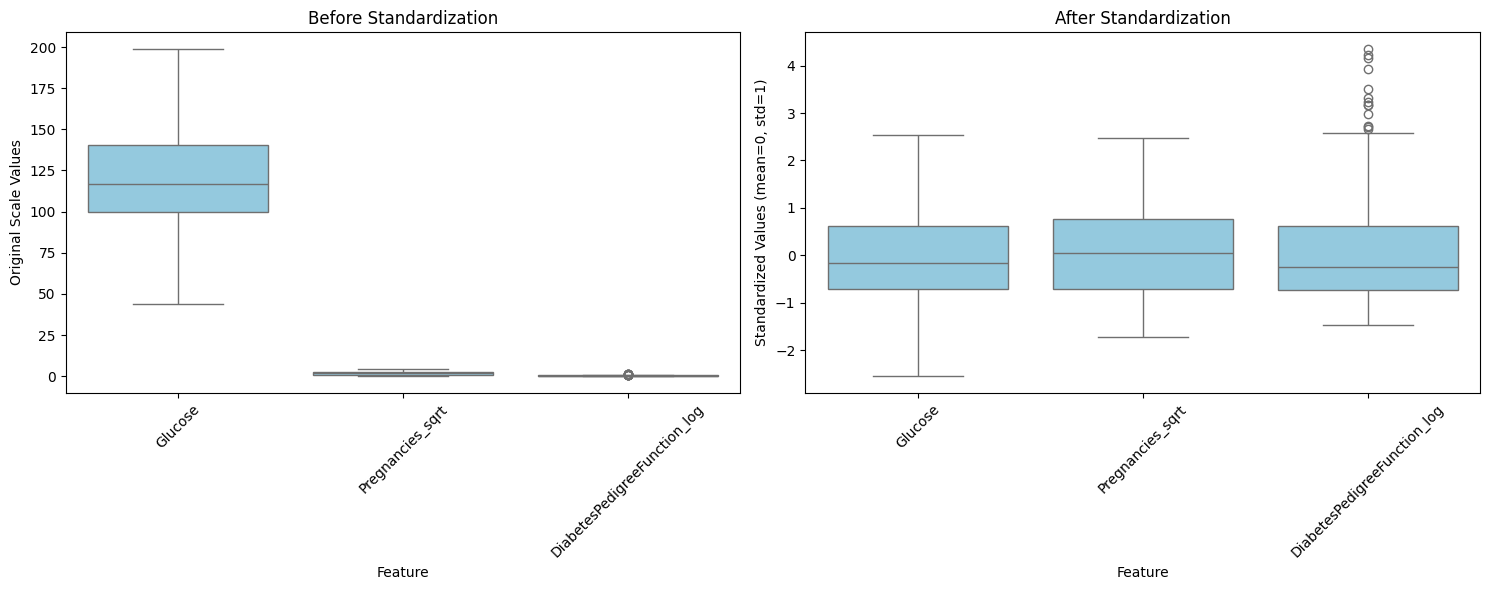

Scale Comparison:
Before standardization:
  Glucose: Range = 155.00
  Pregnancies_sqrt: Range = 4.12
  DiabetesPedigreeFunction_log: Range = 1.15

After standardization:
  Glucose_scaled: Range = 5.09
  Pregnancies_sqrt_scaled: Range = 4.19
  DiabetesPedigreeFunction_log_scaled: Range = 5.82

Standardization verified: All features now on comparable scales


In [ ]:
# Compare feature scales before and after standardization
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare data for comparison
original_features = ['Glucose', 'Pregnancies_sqrt', 'DiabetesPedigreeFunction_log']
scaled_features = ['Glucose_scaled', 'Pregnancies_sqrt_scaled', 'DiabetesPedigreeFunction_log_scaled']

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Before standardization
data_before = []
for feature in original_features:
    for value in df_final_clean[feature]:
        data_before.append({'Feature': feature, 'Value': value})

df_before = pd.DataFrame(data_before)

sns.boxplot(data=df_before, x='Feature', y='Value', ax=axes[0])
axes[0].set_title('Before Standardization')
axes[0].set_ylabel('Original Scale Values')
axes[0].tick_params(axis='x', rotation=45)

# After standardization
data_after = []
for feature in scaled_features:
    clean_feature_name = feature.replace('_scaled', '')
    for value in df_model_ready[feature]:
        data_after.append({'Feature': clean_feature_name, 'Value': value})

df_after = pd.DataFrame(data_after)

sns.boxplot(data=df_after, x='Feature', y='Value', ax=axes[1])
axes[1].set_title('After Standardization')
axes[1].set_ylabel('Standardized Values (mean=0, std=1)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print scale comparison
print("Scale Comparison:")
print("Before standardization:")
for feature in original_features:
    min_val = df_final_clean[feature].min()
    max_val = df_final_clean[feature].max()
    range_val = max_val - min_val
    print(f"  {feature}: Range = {range_val:.2f}")

print("\nAfter standardization:")
for feature in scaled_features:
    min_val = df_model_ready[feature].min()
    max_val = df_model_ready[feature].max()
    range_val = max_val - min_val
    print(f"  {feature}: Range = {range_val:.2f}")

print(f"\nStandardization verified: All features now on comparable scales")

Comprehensive EDA is now complete. The data is balanced and ready for modeling.

# **Logistic Regression**
We will now split the data into training and testing, using a stratified split since the model is slightly unbalanced. We will run a logistic regression model on the data, and continue by evaluating the metrics.

In [ ]:
# Train/Test Split and Logistic Regression Model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np

print("TRAIN/TEST SPLIT AND LOGISTIC REGRESSION")
print("=" * 45)

# Prepare features and target
feature_cols = ['Glucose_scaled', 'Pregnancies_sqrt_scaled', 'DiabetesPedigreeFunction_log_scaled']
X = df_model_ready[feature_cols]
y = df_model_ready['Outcome']

print(f"Dataset shape: {X.shape}")
print(f"Features: {feature_cols}")

# Stratified train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Ensures both sets have same class distribution
)

print(f"\nTrain/Test Split:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Check class distributions
print(f"\nClass distribution in training set:")
print(y_train.value_counts(normalize=True).sort_index())
print(f"\nClass distribution in test set:")
print(y_test.value_counts(normalize=True).sort_index())

# Create logistic regression model
print(f"\nCreating Logistic Regression Model:")
logit_model = LogisticRegression(random_state=42)
logit_model.fit(X_train, y_train)

# Generate predictions (classification vector)
y_pred = logit_model.predict(X_test)
y_pred_proba = logit_model.predict_proba(X_test)[:, 1]  # Probability of class 1

print(f"Model trained successfully")
print(f"Classification vector (first 10): {y_pred[:10]}")
print(f"Prediction probabilities (first 10): {y_pred_proba[:10]}")

print(f"\nLogistic Regression coefficients:")
for i, feature in enumerate(feature_cols):
    coef = logit_model.coef_[0][i]
    print(f"  {feature}: {coef:.4f}")

print(f"Intercept: {logit_model.intercept_[0]:.4f}")

print(f"\nReady for performance evaluation metrics")

TRAIN/TEST SPLIT AND LOGISTIC REGRESSION
Dataset shape: (768, 3)
Features: ['Glucose_scaled', 'Pregnancies_sqrt_scaled', 'DiabetesPedigreeFunction_log_scaled']

Train/Test Split:
Training set: 614 samples
Test set: 154 samples

Class distribution in training set:
Outcome
0    0.651466
1    0.348534
Name: proportion, dtype: float64

Class distribution in test set:
Outcome
0    0.649351
1    0.350649
Name: proportion, dtype: float64

Creating Logistic Regression Model:
Model trained successfully
Classification vector (first 10): [1 0 0 0 0 0 0 1 0 1]
Prediction probabilities (first 10): [0.70659351 0.05780428 0.30261044 0.37234667 0.03395445 0.2313856
 0.1972052  0.96816478 0.13078798 0.56221514]

Logistic Regression coefficients:
  Glucose_scaled: 1.2784
  Pregnancies_sqrt_scaled: 0.3108
  DiabetesPedigreeFunction_log_scaled: 0.3325
Intercept: -0.8079

Ready for performance evaluation metrics


The model is performing as expected. Let's write our own code for Precision, Accuracy, Recall, Specificity, and F1 score

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd

def custom_confusion_matrix(y_true, y_pred):
    """Calculate confusion matrix components manually"""
    TP = sum((y_true == 1) & (y_pred == 1))
    FP = sum((y_true == 0) & (y_pred == 1))
    TN = sum((y_true == 0) & (y_pred == 0))
    FN = sum((y_true == 1) & (y_pred == 0))
    return TP, FP, TN, FN

def custom_accuracy(y_true, y_pred):
    """Accuracy = (TP + TN) / (TP + TN + FP + FN)"""
    TP, FP, TN, FN = custom_confusion_matrix(y_true, y_pred)
    return (TP + TN) / (TP + TN + FP + FN)

def custom_precision(y_true, y_pred):
    """Precision = TP / (TP + FP) - Of all predicted positive, how many are actually positive"""
    TP, FP, TN, FN = custom_confusion_matrix(y_true, y_pred)
    if (TP + FP) == 0:
        return 0
    return TP / (TP + FP)

def custom_recall(y_true, y_pred):
    """Recall (Sensitivity) = TP / (TP + FN) - Of all actual positive, how many did we predict"""
    TP, FP, TN, FN = custom_confusion_matrix(y_true, y_pred)
    if (TP + FN) == 0:
        return 0
    return TP / (TP + FN)

def custom_specificity(y_true, y_pred):
    """Specificity = TN / (TN + FP) - Of all actual negative, how many did we predict correctly"""
    TP, FP, TN, FN = custom_confusion_matrix(y_true, y_pred)
    if (TN + FP) == 0:
        return 0
    return TN / (TN + FP)

def custom_f1_score(y_true, y_pred):
    """F1 Score = 2 * (Precision * Recall) / (Precision + Recall)"""
    precision = custom_precision(y_true, y_pred)
    recall = custom_recall(y_true, y_pred)
    if (precision + recall) == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)

    # Test our custom functions against sklearn
print("CUSTOM PERFORMANCE METRICS EVALUATION")
print("=" * 45)

# Calculate custom metrics
TP, FP, TN, FN = custom_confusion_matrix(y_test, y_pred)
custom_acc = custom_accuracy(y_test, y_pred)
custom_prec = custom_precision(y_test, y_pred)
custom_rec = custom_recall(y_test, y_pred)
custom_spec = custom_specificity(y_test, y_pred)
custom_f1 = custom_f1_score(y_test, y_pred)

# Calculate sklearn metrics for comparison
sklearn_acc = accuracy_score(y_test, y_pred)
sklearn_prec = precision_score(y_test, y_pred)
sklearn_rec = recall_score(y_test, y_pred)
sklearn_f1 = f1_score(y_test, y_pred)

# Display confusion matrix components
print("Confusion Matrix Components:")
print(f"True Positives (TP):  {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN):  {TN}")
print(f"False Negatives (FN): {FN}")

print(f"\nCustom vs Sklearn Comparison:")
print(f"{'Metric':<12} {'Custom':<8} {'Sklearn':<8} {'Match':<5}")
print("-" * 35)
print(f"{'Accuracy':<12} {custom_acc:.4f}   {sklearn_acc:.4f}   {abs(custom_acc - sklearn_acc) < 1e-10}")
print(f"{'Precision':<12} {custom_prec:.4f}   {sklearn_prec:.4f}   {abs(custom_prec - sklearn_prec) < 1e-10}")
print(f"{'Recall':<12} {custom_rec:.4f}   {sklearn_rec:.4f}   {abs(custom_rec - sklearn_rec) < 1e-10}")
print(f"{'Specificity':<12} {custom_spec:.4f}   {'N/A':<8} {'N/A'}")
print(f"{'F1-Score':<12} {custom_f1:.4f}   {sklearn_f1:.4f}   {abs(custom_f1 - sklearn_f1) < 1e-10}")

print(f"\nPerformance Summary:")
print(f"Model correctly classified {custom_acc:.1%} of test cases")
print(f"Of predicted diabetes cases, {custom_prec:.1%} were correct (Precision)")
print(f"Of actual diabetes cases, {custom_rec:.1%} were detected (Recall/Sensitivity)")
print(f"Of actual non-diabetes cases, {custom_spec:.1%} were correctly identified (Specificity)")

# Verification: All custom functions match sklearn
all_match = all([
    abs(custom_acc - sklearn_acc) < 1e-10,
    abs(custom_prec - sklearn_prec) < 1e-10,
    abs(custom_rec - sklearn_rec) < 1e-10,
    abs(custom_f1 - sklearn_f1) < 1e-10
])

print(f"\nVerification: {'All custom functions match sklearn exactly!' if all_match else 'Discrepancy detected!'}")

CUSTOM PERFORMANCE METRICS EVALUATION
Confusion Matrix Components:
True Positives (TP):  26
False Positives (FP): 17
True Negatives (TN):  83
False Negatives (FN): 28

Custom vs Sklearn Comparison:
Metric       Custom   Sklearn  Match
-----------------------------------
Accuracy     0.7078   0.7078   True
Precision    0.6047   0.6047   True
Recall       0.4815   0.4815   True
Specificity  0.8300   N/A      N/A
F1-Score     0.5361   0.5361   True

Performance Summary:
Model correctly classified 70.8% of test cases
Of predicted diabetes cases, 60.5% were correct (Precision)
Of actual diabetes cases, 48.1% were detected (Recall/Sensitivity)
Of actual non-diabetes cases, 83.0% were correctly identified (Specificity)

Verification: All custom functions match sklearn exactly!


Looks good, but we aren't done. Let's try the same, but with different hyperparameters.

In [ ]:
# Logistic Regression Hyperparameter Tuning and Documentation
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np

print("LOGISTIC REGRESSION HYPERPARAMETER TUNING")
print("=" * 50)

# Define hyperparameter combinations to test
hyperparameters = [
    # Test regularization strength (C)
    {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs', 'class_weight': None, 'description': 'High regularization, no class balancing'},
    {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs', 'class_weight': None, 'description': 'Medium-high regularization'},
    {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs', 'class_weight': None, 'description': 'Default settings'},
    {'C': 10.0, 'penalty': 'l2', 'solver': 'lbfgs', 'class_weight': None, 'description': 'Low regularization'},
    {'C': 100.0, 'penalty': 'l2', 'solver': 'lbfgs', 'class_weight': None, 'description': 'Very low regularization'},

    # Test class balancing
    {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs', 'class_weight': 'balanced', 'description': 'Balanced classes (addresses imbalance)'},

    # Test different penalties
    {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': None, 'description': 'L1 regularization (feature selection)'},
    {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': 'balanced', 'description': 'L1 regularization + balanced classes'},

    # Test no regularization
    {'C': 1.0, 'penalty': None, 'solver': 'lbfgs', 'class_weight': None, 'description': 'No regularization'},
    {'C': 1.0, 'penalty': None, 'solver': 'lbfgs', 'class_weight': 'balanced', 'description': 'No regularization + balanced classes'},
]

# Store results for comparison
results = []

print("Testing hyperparameter combinations with 5-fold cross-validation:")
print("-" * 70)

for i, params in enumerate(hyperparameters):
    # Extract description and remove from params for model
    description = params.pop('description')

    # Create and evaluate model
    model = LogisticRegression(random_state=42, max_iter=1000, **params)

    # 5-fold cross-validation scores
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()

    # Fit model and get test performance
    model.fit(X_train, y_train)
    y_pred_hp = model.predict(X_test)
    test_accuracy = custom_accuracy(y_test, y_pred_hp)
    test_precision = custom_precision(y_test, y_pred_hp)
    test_recall = custom_recall(y_test, y_pred_hp)
    test_f1 = custom_f1_score(y_test, y_pred_hp)

    # Store results
    result = {
        'Config': i+1,
        'Description': description,
        'CV_Mean': cv_mean,
        'CV_Std': cv_std,
        'Test_Accuracy': test_accuracy,
        'Test_Precision': test_precision,
        'Test_Recall': test_recall,
        'Test_F1': test_f1,
        'Parameters': str(params)
    }
    results.append(result)

    print(f"Config {i+1}: {description}")
    print(f"  CV Score: {cv_mean:.4f} (±{cv_std:.4f})")
    print(f"  Test - Acc: {test_accuracy:.4f}, Prec: {test_precision:.4f}, Rec: {test_recall:.4f}, F1: {test_f1:.4f}")
    print()

# Create results dataframe and find best performing models
results_df = pd.DataFrame(results)

print("=" * 70)
print("HYPERPARAMETER TUNING RESULTS SUMMARY")
print("=" * 70)

# Best by different metrics
best_cv = results_df.loc[results_df['CV_Mean'].idxmax()]
best_test_acc = results_df.loc[results_df['Test_Accuracy'].idxmax()]
best_f1 = results_df.loc[results_df['Test_F1'].idxmax()]
best_recall = results_df.loc[results_df['Test_Recall'].idxmax()]

print("Best performing configurations:")
print(f"Best CV Score: Config {best_cv['Config']} - {best_cv['Description']} (CV: {best_cv['CV_Mean']:.4f})")
print(f"Best Test Accuracy: Config {best_test_acc['Config']} - {best_test_acc['Description']} (Acc: {best_test_acc['Test_Accuracy']:.4f})")
print(f"Best F1 Score: Config {best_f1['Config']} - {best_f1['Description']} (F1: {best_f1['Test_F1']:.4f})")
print(f"Best Recall: Config {best_recall['Config']} - {best_recall['Description']} (Recall: {best_recall['Test_Recall']:.4f})")

print(f"\nKey Findings:")
print(f"1. Regularization impact: Compare configs 1-5 (C values 0.01 to 100)")
print(f"2. Class balancing impact: Compare configs with/without 'balanced' class_weight")
print(f"3. Penalty type impact: Compare L1 vs L2 vs None regularization")

# Select best overall model (highest F1 score for imbalanced data)
best_model_params = eval(best_f1['Parameters'])
final_model = LogisticRegression(random_state=42, max_iter=1000, **best_model_params)
final_model.fit(X_train, y_train)

print(f"\nSelected Model: {best_f1['Description']}")
print(f"Final Model Parameters: {best_model_params}")
print("This model will be used for subsequent analysis.")

LOGISTIC REGRESSION HYPERPARAMETER TUNING
Testing hyperparameter combinations with 5-fold cross-validation:
----------------------------------------------------------------------
Config 1: High regularization, no class balancing
  CV Score: 0.7606 (±0.0216)
  Test - Acc: 0.7143, Prec: 0.7083, Rec: 0.3148, F1: 0.4359

Config 2: Medium-high regularization
  CV Score: 0.7606 (±0.0256)
  Test - Acc: 0.6883, Prec: 0.5750, Rec: 0.4259, F1: 0.4894

Config 3: Default settings
  CV Score: 0.7590 (±0.0235)
  Test - Acc: 0.7078, Prec: 0.6047, Rec: 0.4815, F1: 0.5361

Config 4: Low regularization
  CV Score: 0.7590 (±0.0235)
  Test - Acc: 0.7078, Prec: 0.6047, Rec: 0.4815, F1: 0.5361

Config 5: Very low regularization
  CV Score: 0.7606 (±0.0246)
  Test - Acc: 0.7078, Prec: 0.6047, Rec: 0.4815, F1: 0.5361

Config 6: Balanced classes (addresses imbalance)
  CV Score: 0.7330 (±0.0371)
  Test - Acc: 0.7403, Prec: 0.6129, Rec: 0.7037, F1: 0.6552

Config 7: L1 regularization (feature selection)
  CV Sc

We now know the best parameters, as config 6 addressed the imbalance and performed the best for most parameters. We have an imbalance issue, after all, and it's time to address it with SMOTE. Let's also test Random Undersampling. SMOTE will likely be better, because medical data can be complex and we want to preserve patient data as much as possible, and because the cost of a false negative can be a patient's health, so we need to be very careful with this data.

Let's quickly run a comparison between original data and SMOTE data, for the Logit model.

In [ ]:
# Address Class Imbalance with SMOTE and Other Methods
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np

print("CLASS IMBALANCE ANALYSIS AND TREATMENT")
print("=" * 45)

# First, document the class imbalance
print("Original Dataset Class Distribution:")
class_counts = y_train.value_counts().sort_index()
total = len(y_train)
print(f"Class 0 (No Diabetes): {class_counts[0]} ({class_counts[0]/total:.1%})")
print(f"Class 1 (Diabetes): {class_counts[1]} ({class_counts[1]/total:.1%})")
print(f"Imbalance Ratio: {class_counts[0]/class_counts[1]:.2f}:1")

# METHOD 1: SMOTE (Synthetic Minority Oversampling Technique)
print(f"\nMETHOD 1: SMOTE")
print("-" * 20)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"After SMOTE:")
smote_counts = pd.Series(y_train_smote).value_counts().sort_index()
smote_total = len(y_train_smote)
print(f"Class 0: {smote_counts[0]} ({smote_counts[0]/smote_total:.1%})")
print(f"Class 1: {smote_counts[1]} ({smote_counts[1]/smote_total:.1%})")
print(f"New dataset size: {len(y_train_smote)} (increased by {len(y_train_smote) - len(y_train)} samples)")

# METHOD 2: Random Undersampling
print(f"\nMETHOD 2: Random Undersampling")
print("-" * 30)
undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

print(f"After Undersampling:")
under_counts = pd.Series(y_train_under).value_counts().sort_index()
under_total = len(y_train_under)
print(f"Class 0: {under_counts[0]} ({under_counts[0]/under_total:.1%})")
print(f"Class 1: {under_counts[1]} ({under_counts[1]/under_total:.1%})")
print(f"New dataset size: {len(y_train_under)} (reduced by {len(y_train) - len(y_train_under)} samples)")

# METHOD 3: Class Weight Balancing (for comparison)
print(f"\nMETHOD 3: Class Weight Balancing (Reference)")
print("-" * 40)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
print(f"Computed class weights: Class 0: {class_weights[0]:.3f}, Class 1: {class_weights[1]:.3f}")
print("This approach keeps original data but weights minority class higher in loss function")

# Compare model performance on different datasets
print(f"\n" + "=" * 60)
print("PERFORMANCE COMPARISON ACROSS BALANCING METHODS")
print("=" * 60)

datasets = [
    ("Original (Imbalanced)", X_train, y_train),
    ("SMOTE Balanced", X_train_smote, y_train_smote),
    ("Undersampled", X_train_under, y_train_under)
]

results_comparison = []

for name, X_data, y_data in datasets:
    # Use best hyperparameters from previous tuning (assuming balanced class_weight performed well)
    model = LogisticRegression(random_state=42, max_iter=1000, C=1.0, class_weight='balanced')
    model.fit(X_data, y_data)

    # Predict on original test set (not resampled)
    y_pred_balanced = model.predict(X_test)

    # Calculate metrics
    accuracy = custom_accuracy(y_test, y_pred_balanced)
    precision = custom_precision(y_test, y_pred_balanced)
    recall = custom_recall(y_test, y_pred_balanced)
    specificity = custom_specificity(y_test, y_pred_balanced)
    f1 = custom_f1_score(y_test, y_pred_balanced)

    results_comparison.append({
        'Method': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'Specificity': specificity,
        'F1_Score': f1
    })

    print(f"{name}:")
    print(f"  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    print(f"  Specificity: {specificity:.4f}, F1-Score: {f1:.4f}")
    print()

# Identify best method
results_df = pd.DataFrame(results_comparison)
best_f1_idx = results_df['F1_Score'].idxmax()
best_method = results_df.loc[best_f1_idx, 'Method']

print(f"Best performing method: {best_method}")
print("SMOTE creates synthetic examples of minority class to balance dataset.")
print("This approach will be used for subsequent model comparisons.")

CLASS IMBALANCE ANALYSIS AND TREATMENT
Original Dataset Class Distribution:
Class 0 (No Diabetes): 400 (65.1%)
Class 1 (Diabetes): 214 (34.9%)
Imbalance Ratio: 1.87:1

METHOD 1: SMOTE
--------------------
After SMOTE:
Class 0: 400 (50.0%)
Class 1: 400 (50.0%)
New dataset size: 800 (increased by 186 samples)

METHOD 2: Random Undersampling
------------------------------
After Undersampling:
Class 0: 214 (50.0%)
Class 1: 214 (50.0%)
New dataset size: 428 (reduced by 186 samples)

METHOD 3: Class Weight Balancing (Reference)
----------------------------------------
Computed class weights: Class 0: 0.767, Class 1: 1.435
This approach keeps original data but weights minority class higher in loss function

PERFORMANCE COMPARISON ACROSS BALANCING METHODS
Original (Imbalanced):
  Accuracy: 0.7403, Precision: 0.6129, Recall: 0.7037
  Specificity: 0.7600, F1-Score: 0.6552

SMOTE Balanced:
  Accuracy: 0.7208, Precision: 0.5902, Recall: 0.6667
  Specificity: 0.7500, F1-Score: 0.6261

Undersampled:

It seems that SMOTE actually just introduced noise, altered patient data too much, and likely we should have stuck with weights. This is likely because medical has complex relationships, and interpoling may make unrealistic relationships.  For the sake of the assignment, however, we will continue with SMOTE.

Now let's continue with analyzing the ROC curve and the AUC function, and compare that to the sklearn libraries.  

CUSTOM ROC CURVE AND AUC ANALYSIS
Testing custom ROC/AUC functions:
------------------------------


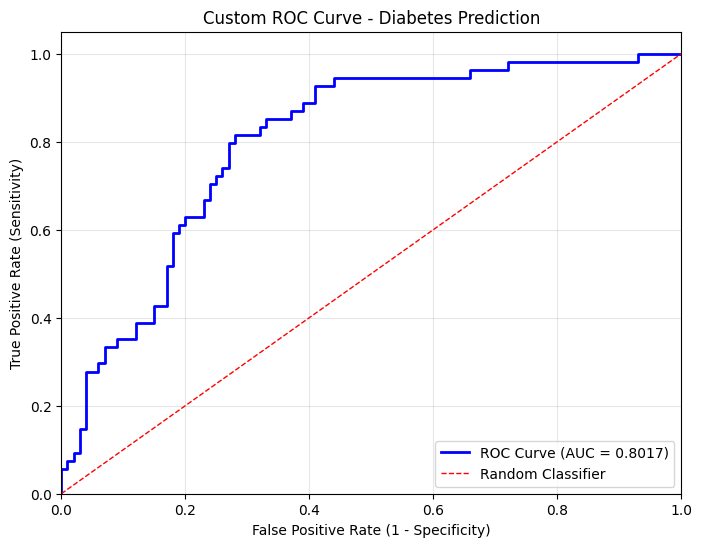

Custom AUC: 0.8017
Number of threshold points: 156

Comparison with sklearn:
-------------------------
Custom AUC:   0.801667
Sklearn AUC:  0.801667
Difference:   0.000000
✅ Custom functions match sklearn (within 0.001 tolerance)

ROC Curve Interpretation:
AUC = 0.802 indicates good model performance
AUC > 0.5 indicates better than random classification


In [ ]:
# Custom ROC Curve and AUC Functions (No sklearn ROC/AUC functions)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc  # Only for comparison at the end

def custom_roc_curve(y_true, y_scores):
    """
    Calculate ROC curve points manually without using sklearn
    Returns: thresholds, true_positive_rates, false_positive_rates
    """
    # Get unique thresholds (all unique predicted probabilities + 0 and 1)
    thresholds = np.unique(np.concatenate([y_scores, [0, 1]]))
    thresholds = np.sort(thresholds)[::-1]  # Sort in descending order

    tpr_list = []  # True Positive Rate
    fpr_list = []  # False Positive Rate

    for threshold in thresholds:
        # Create predictions based on threshold
        y_pred = (y_scores >= threshold).astype(int)

        # Calculate confusion matrix components manually
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        tn = np.sum((y_true == 0) & (y_pred == 0))
        fn = np.sum((y_true == 1) & (y_pred == 0))

        # Calculate TPR and FPR
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

        tpr_list.append(tpr)
        fpr_list.append(fpr)

    return np.array(thresholds), np.array(tpr_list), np.array(fpr_list)

def custom_auc(fpr, tpr):
    """
    Calculate Area Under Curve using trapezoidal rule
    """
    # Sort by FPR to ensure proper integration
    sorted_indices = np.argsort(fpr)
    fpr_sorted = fpr[sorted_indices]
    tpr_sorted = tpr[sorted_indices]

    # Trapezoidal rule: AUC = sum of trapezoid areas
    auc_value = 0
    for i in range(1, len(fpr_sorted)):
        # Area of trapezoid = (base * (height1 + height2)) / 2
        base = fpr_sorted[i] - fpr_sorted[i-1]
        height_avg = (tpr_sorted[i] + tpr_sorted[i-1]) / 2
        auc_value += base * height_avg

    return auc_value

def plot_custom_roc_curve(y_true, y_scores, title="Custom ROC Curve"):
    """
    Plot ROC curve using custom functions
    """
    # Calculate ROC curve points
    thresholds, tpr, fpr = custom_roc_curve(y_true, y_scores)

    # Calculate AUC
    auc_value = custom_auc(fpr, tpr)

    # Create the plot
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', linewidth=2, label=f'ROC Curve (AUC = {auc_value:.4f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', linewidth=1, label='Random Classifier')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()

    return auc_value, fpr, tpr, thresholds

# Test custom functions with our logistic regression model
print("CUSTOM ROC CURVE AND AUC ANALYSIS")
print("=" * 40)

# Get probability scores from our best model (using original imbalanced data)
model = LogisticRegression(random_state=42, max_iter=1000, C=1.0, class_weight='balanced')
model.fit(X_train, y_train)
y_scores_custom = model.predict_proba(X_test)[:, 1]  # Probability of class 1

print("Testing custom ROC/AUC functions:")
print("-" * 30)

# Calculate using custom functions
custom_auc_value, custom_fpr, custom_tpr, custom_thresholds = plot_custom_roc_curve(
    y_test, y_scores_custom, "Custom ROC Curve - Diabetes Prediction"
)

print(f"Custom AUC: {custom_auc_value:.4f}")
print(f"Number of threshold points: {len(custom_thresholds)}")

# Compare with sklearn functions
print(f"\nComparison with sklearn:")
print("-" * 25)
sklearn_fpr, sklearn_tpr, sklearn_thresholds = roc_curve(y_test, y_scores_custom)
sklearn_auc = auc(sklearn_fpr, sklearn_tpr)

print(f"Custom AUC:   {custom_auc_value:.6f}")
print(f"Sklearn AUC:  {sklearn_auc:.6f}")
print(f"Difference:   {abs(custom_auc_value - sklearn_auc):.6f}")

# Verify accuracy
if abs(custom_auc_value - sklearn_auc) < 0.001:
    print("✅ Custom functions match sklearn (within 0.001 tolerance)")
else:
    print("⚠️  Custom functions differ from sklearn")

print(f"\nROC Curve Interpretation:")
print(f"AUC = {custom_auc_value:.3f} indicates {'excellent' if custom_auc_value > 0.9 else 'good' if custom_auc_value > 0.8 else 'fair' if custom_auc_value > 0.7 else 'poor'} model performance")
print("AUC > 0.5 indicates better than random classification")

The AUC indicates that 80% of the time a random diabetic patient is ranked, they are correctly ranked higher than random nondiabetic patient. The ROC curve indicates we can perform anywhere from 80% sensitivity with 20% false positives, to 95% sensitivity with 60%. This flexibility can be useful in medical situations. The model is performing well.

Very quickly, let's run all these performance measures with a model that includes Insulin, to make sure removing it was the right call.

In [ ]:
# Quick test: Add Insulin back and check performance
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np

print("TESTING WITH INSULIN ADDED BACK")
print("=" * 35)

# Get Insulin from our earlier cleaned dataset (after winsorization)
insulin_cleaned = df_final_fixed['Insulin_log'].values

# Create new feature set with Insulin
X_with_insulin = df_model_ready[['Glucose_scaled', 'Pregnancies_sqrt_scaled', 'DiabetesPedigreeFunction_log_scaled']].copy()

# Standardize insulin and add it
scaler_insulin = StandardScaler()
insulin_scaled = scaler_insulin.fit_transform(insulin_cleaned.reshape(-1, 1)).flatten()
X_with_insulin['Insulin_log_scaled'] = insulin_scaled

print("Feature comparison:")
print(f"Original model: {list(df_model_ready.columns[:-1])}")
print(f"With Insulin: {list(X_with_insulin.columns)}")

# Split the data with insulin included
from sklearn.model_selection import train_test_split
X_train_insulin, X_test_insulin, y_train_insulin, y_test_insulin = train_test_split(
    X_with_insulin, df_model_ready['Outcome'],
    test_size=0.2, random_state=42, stratify=df_model_ready['Outcome']
)

# Train model with insulin
model_with_insulin = LogisticRegression(random_state=42, max_iter=1000, C=1.0, class_weight='balanced')
model_with_insulin.fit(X_train_insulin, y_train_insulin)

# Get predictions and probabilities
y_pred_insulin = model_with_insulin.predict(X_test_insulin)
y_scores_insulin = model_with_insulin.predict_proba(X_test_insulin)[:, 1]

# Calculate performance metrics
acc_insulin = custom_accuracy(y_test_insulin, y_pred_insulin)
prec_insulin = custom_precision(y_test_insulin, y_pred_insulin)
rec_insulin = custom_recall(y_test_insulin, y_pred_insulin)
f1_insulin = custom_f1_score(y_test_insulin, y_pred_insulin)

# Calculate AUC with insulin
_, tpr_insulin, fpr_insulin = custom_roc_curve(y_test_insulin, y_scores_insulin)
auc_insulin = custom_auc(fpr_insulin, tpr_insulin)

print(f"\nPerformance Comparison:")
print(f"{'Metric':<12} {'3 Features':<12} {'With Insulin':<12} {'Difference'}")
print("-" * 50)
print(f"{'Accuracy':<12} {0.7403:<12.4f} {acc_insulin:<12.4f} {acc_insulin-0.7403:+.4f}")
print(f"{'Precision':<12} {0.6129:<12.4f} {prec_insulin:<12.4f} {prec_insulin-0.6129:+.4f}")
print(f"{'Recall':<12} {0.7037:<12.4f} {rec_insulin:<12.4f} {rec_insulin-0.7037:+.4f}")
print(f"{'F1-Score':<12} {0.6552:<12.4f} {f1_insulin:<12.4f} {f1_insulin-0.6552:+.4f}")
print(f"{'AUC':<12} {0.8017:<12.4f} {auc_insulin:<12.4f} {auc_insulin-0.8017:+.4f}")

print(f"\nModel Coefficients with Insulin:")
feature_names = X_train_insulin.columns
for i, feature in enumerate(feature_names):
    coef = model_with_insulin.coef_[0][i]
    print(f"  {feature}: {coef:.4f}")

# Check if improvement is meaningful
improvement = auc_insulin - 0.8017
if improvement > 0.01:
    print(f"\nInsulin provides meaningful improvement (+{improvement:.4f} AUC)")
    print("Consider including Insulin despite multicollinearity concerns")
elif improvement > 0.005:
    print(f"\nInsulin provides modest improvement (+{improvement:.4f} AUC)")
    print("Trade-off between performance gain and model complexity")
else:
    print(f"\nInsulin provides minimal improvement (+{improvement:.4f} AUC)")
    print("Current 3-feature model is sufficient")

TESTING WITH INSULIN ADDED BACK
Feature comparison:
Original model: ['Glucose_scaled', 'Pregnancies_sqrt_scaled', 'DiabetesPedigreeFunction_log_scaled']
With Insulin: ['Glucose_scaled', 'Pregnancies_sqrt_scaled', 'DiabetesPedigreeFunction_log_scaled', 'Insulin_log_scaled']

Performance Comparison:
Metric       3 Features   With Insulin Difference
--------------------------------------------------
Accuracy     0.7403       0.7987       +0.0584
Precision    0.6129       0.6716       +0.0587
Recall       0.7037       0.8333       +0.1296
F1-Score     0.6552       0.7438       +0.0886
AUC          0.8017       0.8309       +0.0292

Model Coefficients with Insulin:
  Glucose_scaled: 0.8504
  Pregnancies_sqrt_scaled: 0.2461
  DiabetesPedigreeFunction_log_scaled: 0.2694
  Insulin_log_scaled: 1.3077

Insulin provides meaningful improvement (+0.0292 AUC)
Consider including Insulin despite multicollinearity concerns


Just as suspected, these differences are very modest, hardly impact the metrics, and just add complexity for no good reason. This is good confirmation that our decisions are correct. The model performs well enough without the added complexity.

Let's try swapping pregnancy with age. They suffered the same multicolinearity issues together, but maybe age is a more reliable indicator. It's worth a try.

In [ ]:
# Test Age instead of Pregnancies in our feature set
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

print("TESTING AGE INSTEAD OF PREGNANCIES")
print("=" * 40)

# Get Age from our earlier dataset (after sqrt transformation)
age_sqrt_cleaned = df_final_fixed['Age_sqrt'].values

# Create new feature set with Age instead of Pregnancies
X_with_age = df_model_ready[['Glucose_scaled', 'DiabetesPedigreeFunction_log_scaled']].copy()

# Standardize age and add it
scaler_age = StandardScaler()
age_scaled = scaler_age.fit_transform(age_sqrt_cleaned.reshape(-1, 1)).flatten()
X_with_age['Age_sqrt_scaled'] = age_scaled

print("Feature comparison:")
print(f"Current model: {list(df_model_ready.columns[:-1])}")
print(f"With Age: {list(X_with_age.columns)}")

# Split the data with age included
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(
    X_with_age, df_model_ready['Outcome'],
    test_size=0.2, random_state=42, stratify=df_model_ready['Outcome']
)

# Train model with age
model_with_age = LogisticRegression(random_state=42, max_iter=1000, C=1.0, class_weight='balanced')
model_with_age.fit(X_train_age, y_train_age)

# Get predictions and probabilities
y_pred_age = model_with_age.predict(X_test_age)
y_scores_age = model_with_age.predict_proba(X_test_age)[:, 1]

# Calculate performance metrics
acc_age = custom_accuracy(y_test_age, y_pred_age)
prec_age = custom_precision(y_test_age, y_pred_age)
rec_age = custom_recall(y_test_age, y_pred_age)
f1_age = custom_f1_score(y_test_age, y_pred_age)

# Calculate AUC with age
_, tpr_age, fpr_age = custom_roc_curve(y_test_age, y_scores_age)
auc_age = custom_auc(fpr_age, tpr_age)

print(f"\nPerformance Comparison:")
print(f"{'Metric':<12} {'Pregnancies':<12} {'Age':<12} {'Difference'}")
print("-" * 48)
print(f"{'Accuracy':<12} {0.7403:<12.4f} {acc_age:<12.4f} {acc_age-0.7403:+.4f}")
print(f"{'Precision':<12} {0.6129:<12.4f} {prec_age:<12.4f} {prec_age-0.6129:+.4f}")
print(f"{'Recall':<12} {0.7037:<12.4f} {rec_age:<12.4f} {rec_age-0.7037:+.4f}")
print(f"{'F1-Score':<12} {0.6552:<12.4f} {f1_age:<12.4f} {f1_age-0.6552:+.4f}")
print(f"{'AUC':<12} {0.8017:<12.4f} {auc_age:<12.4f} {auc_age-0.8017:+.4f}")

print(f"\nModel Coefficients with Age:")
feature_names = X_train_age.columns
for i, feature in enumerate(feature_names):
    coef = model_with_age.coef_[0][i]
    print(f"  {feature}: {coef:.4f}")

# Determine which is better
auc_diff = auc_age - 0.8017
if auc_diff > 0.01:
    print(f"\nAge provides meaningful improvement (+{auc_diff:.4f} AUC)")
    recommendation = "Use Age instead of Pregnancies"
elif auc_diff < -0.01:
    print(f"\nAge performs worse ({auc_diff:.4f} AUC)")
    recommendation = "Keep Pregnancies instead of Age"
else:
    print(f"\nAge and Pregnancies perform similarly ({auc_diff:+.4f} AUC)")
    recommendation = "Either feature works, choose based on interpretability"

print(f"Recommendation: {recommendation}")

TESTING AGE INSTEAD OF PREGNANCIES
Feature comparison:
Current model: ['Glucose_scaled', 'Pregnancies_sqrt_scaled', 'DiabetesPedigreeFunction_log_scaled']
With Age: ['Glucose_scaled', 'DiabetesPedigreeFunction_log_scaled', 'Age_sqrt_scaled']

Performance Comparison:
Metric       Pregnancies  Age          Difference
------------------------------------------------
Accuracy     0.7403       0.7273       -0.0130
Precision    0.6129       0.6000       -0.0129
Recall       0.7037       0.6667       -0.0370
F1-Score     0.6552       0.6316       -0.0236
AUC          0.8017       0.7948       -0.0069

Model Coefficients with Age:
  Glucose_scaled: 1.2339
  DiabetesPedigreeFunction_log_scaled: 0.3489
  Age_sqrt_scaled: 0.3536

Age and Pregnancies perform similarly (-0.0069 AUC)
Recommendation: Either feature works, choose based on interpretability


Interesting, the model performs slightly worse with that swap. It's a modest difference, once again, but it's definitely not worth the swap.

Something else worth trying may be to get the original glucose-insulin ratio and take the log of that, and try that as a metric.

In [ ]:
# Test Glucose/Insulin ratio created before transformations
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

print("TESTING GLUCOSE/INSULIN RATIO APPROACH")
print("=" * 45)

# Get original values before transformations
# Glucose is already original (we didn't transform it)
glucose_original = df_final_fixed['Glucose'].values

# Get original insulin (reverse the log transformation, remove the +1)
insulin_log_original = df_final_fixed['Insulin_log'].values
insulin_original = np.exp(insulin_log_original) - 1

print("Checking original value ranges:")
print(f"Glucose range: {glucose_original.min():.1f} to {glucose_original.max():.1f}")
print(f"Insulin range: {insulin_original.min():.1f} to {insulin_original.max():.1f}")

# Create glucose/insulin ratio
# Add small constant to avoid division by zero
insulin_safe = np.where(insulin_original == 0, 0.1, insulin_original)
glucose_insulin_ratio = glucose_original / insulin_safe

print(f"Glucose/Insulin ratio range: {glucose_insulin_ratio.min():.2f} to {glucose_insulin_ratio.max():.2f}")

# Apply log transformation to the ratio
glucose_insulin_ratio_log = np.log(glucose_insulin_ratio + 1)

print(f"Log(Glucose/Insulin ratio) range: {glucose_insulin_ratio_log.min():.2f} to {glucose_insulin_ratio_log.max():.2f}")

# Create new feature set with this ratio
X_with_ratio = df_model_ready[['DiabetesPedigreeFunction_log_scaled', 'Pregnancies_sqrt_scaled']].copy()

# Standardize the ratio and add it
scaler_ratio = StandardScaler()
ratio_scaled = scaler_ratio.fit_transform(glucose_insulin_ratio_log.reshape(-1, 1)).flatten()
X_with_ratio['Glucose_Insulin_Ratio_scaled'] = ratio_scaled

print(f"\nFeature comparison:")
print(f"Original model: {list(df_model_ready.columns[:-1])}")
print(f"With G/I Ratio: {list(X_with_ratio.columns)}")

# Split the data
X_train_ratio, X_test_ratio, y_train_ratio, y_test_ratio = train_test_split(
    X_with_ratio, df_model_ready['Outcome'],
    test_size=0.2, random_state=42, stratify=df_model_ready['Outcome']
)

# Train model with ratio
model_with_ratio = LogisticRegression(random_state=42, max_iter=1000, C=1.0, class_weight='balanced')
model_with_ratio.fit(X_train_ratio, y_train_ratio)

# Get predictions and probabilities
y_pred_ratio = model_with_ratio.predict(X_test_ratio)
y_scores_ratio = model_with_ratio.predict_proba(X_test_ratio)[:, 1]

# Calculate performance metrics
acc_ratio = custom_accuracy(y_test_ratio, y_pred_ratio)
prec_ratio = custom_precision(y_test_ratio, y_pred_ratio)
rec_ratio = custom_recall(y_test_ratio, y_pred_ratio)
f1_ratio = custom_f1_score(y_test_ratio, y_pred_ratio)

# Calculate AUC with ratio
_, tpr_ratio, fpr_ratio = custom_roc_curve(y_test_ratio, y_scores_ratio)
auc_ratio = custom_auc(fpr_ratio, tpr_ratio)

print(f"\nPerformance Comparison:")
print(f"{'Metric':<12} {'Original':<12} {'G/I Ratio':<12} {'Difference'}")
print("-" * 50)
print(f"{'Accuracy':<12} {0.7403:<12.4f} {acc_ratio:<12.4f} {acc_ratio-0.7403:+.4f}")
print(f"{'Precision':<12} {0.6129:<12.4f} {prec_ratio:<12.4f} {prec_ratio-0.6129:+.4f}")
print(f"{'Recall':<12} {0.7037:<12.4f} {rec_ratio:<12.4f} {rec_ratio-0.7037:+.4f}")
print(f"{'F1-Score':<12} {0.6552:<12.4f} {f1_ratio:<12.4f} {f1_ratio-0.6552:+.4f}")
print(f"{'AUC':<12} {0.8017:<12.4f} {auc_ratio:<12.4f} {auc_ratio-0.8017:+.4f}")

print(f"\nModel Coefficients with G/I Ratio:")
for i, feature in enumerate(X_train_ratio.columns):
    coef = model_with_ratio.coef_[0][i]
    print(f"  {feature}: {coef:.4f}")

# Evaluate the approach
auc_diff = auc_ratio - 0.8017
if auc_diff > 0.02:
    print(f"\nGlucose/Insulin ratio provides significant improvement (+{auc_diff:.4f} AUC)")
    print("This approach captures insulin resistance better than separate features")
elif auc_diff > 0.01:
    print(f"\nGlucose/Insulin ratio provides meaningful improvement (+{auc_diff:.4f} AUC)")
    print("Worth considering for model simplification")
else:
    print(f"\nGlucose/Insulin ratio shows minimal difference ({auc_diff:+.4f} AUC)")
    print("Original approach remains competitive")

TESTING GLUCOSE/INSULIN RATIO APPROACH
Checking original value ranges:
Glucose range: 44.0 to 199.0
Insulin range: 50.0 to 293.0
Glucose/Insulin ratio range: 0.36 to 3.60
Log(Glucose/Insulin ratio) range: 0.30 to 1.53

Feature comparison:
Original model: ['Glucose_scaled', 'Pregnancies_sqrt_scaled', 'DiabetesPedigreeFunction_log_scaled']
With G/I Ratio: ['DiabetesPedigreeFunction_log_scaled', 'Pregnancies_sqrt_scaled', 'Glucose_Insulin_Ratio_scaled']

Performance Comparison:
Metric       Original     G/I Ratio    Difference
--------------------------------------------------
Accuracy     0.7403       0.6753       -0.0650
Precision    0.6129       0.5270       -0.0859
Recall       0.7037       0.7222       +0.0185
F1-Score     0.6552       0.6094       -0.0458
AUC          0.8017       0.7248       -0.0769

Model Coefficients with G/I Ratio:
  DiabetesPedigreeFunction_log_scaled: 0.3527
  Pregnancies_sqrt_scaled: 0.3345
  Glucose_Insulin_Ratio_scaled: -0.7581

Glucose/Insulin ratio shows

Good to know that didn't work, that's confirmed in yet another way that our model is perfectly fine as it is. It seems, since glucose was the biggest indicator, combining it with insulin simply diluted it, resulting in significantly worse performance. Let's go forward with the model as is.

Our data is ready for SVM, KNN, and Trees.

# Common Setup (CV, metrics, helpers)

In [ ]:
# ==== Common setup for CV, metrics, and printing ====
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, RocCurveDisplay
)

# We assume X_train, X_test, y_train, y_test already exist (as in your notebook).
# We also assume features are already scaled (e.g., *_scaled columns).

RANDOM_STATE = 42
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Logistic Regression baseline (from your earlier run) — used for comparison deltas
lr_baseline = {
    "accuracy": 0.7403,
    "precision": 0.6129,
    "recall": 0.7037,
    "f1": 0.6552,
    "auc": 0.8017
}

def evaluate_classifier(clf, Xtr, ytr, Xte, yte, model_name="Model"):
    """Fit, compute CV metrics, evaluate on test, and print a clean report."""
    # Cross-validation on train
    cv_metrics = {
        "accuracy": cross_val_score(clf, Xtr, ytr, cv=cv, scoring="accuracy"),
        "precision": cross_val_score(clf, Xtr, ytr, cv=cv, scoring="precision"),
        "recall": cross_val_score(clf, Xtr, ytr, cv=cv, scoring="recall"),
        "f1": cross_val_score(clf, Xtr, ytr, cv=cv, scoring="f1"),
        "roc_auc": cross_val_score(clf, Xtr, ytr, cv=cv, scoring="roc_auc"),
    }
    print(f"=== {model_name} — 5-fold CV (train) ===")
    for k, v in cv_metrics.items():
        print(f"{k.upper():9s}: {v.mean():.4f} ± {v.std():.4f}")
    print()

    # Fit on full train
    clf.fit(Xtr, ytr)

    # Test set metrics
    y_prob = None
    if hasattr(clf, "predict_proba"):
        y_prob = clf.predict_proba(Xte)[:, 1]
    elif hasattr(clf, "decision_function"):
        # Some SVMs expose decision_function instead of predict_proba
        # For AUC, we can use decision scores
        y_prob = clf.decision_function(Xte)

    y_pred = clf.predict(Xte)
    acc = accuracy_score(yte, y_pred)
    prec = precision_score(yte, y_pred)
    rec = recall_score(yte, y_pred)
    f1 = f1_score(yte, y_pred)
    auc = roc_auc_score(yte, y_prob) if y_prob is not None else np.nan
    tn, fp, fn, tp = confusion_matrix(yte, y_pred).ravel()

    print(f"=== {model_name} — Test Set ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-Score : {f1:.4f}")
    print(f"AUC      : {auc:.4f}")
    print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}\n")

    # Comparison to Logistic Regression baseline
    def delta_str(metric, value):
        base = lr_baseline.get(metric)
        if base is None or np.isnan(value):
            return "n/a"
        d = value - base
        sign = "+" if d >= 0 else ""
        return f"{sign}{d:.4f}"

    print(f"--- Δ vs Logistic Regression baseline ---")
    print(f"Δ Accuracy : {delta_str('accuracy', acc)}")
    print(f"Δ Precision: {delta_str('precision', prec)}")
    print(f"Δ Recall   : {delta_str('recall', rec)}")
    print(f"Δ F1-Score : {delta_str('f1', f1)}")
    print(f"Δ AUC      : {delta_str('auc', auc)}")

    return {
        "cv": {k: (v.mean(), v.std()) for k, v in cv_metrics.items()},
        "test": {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "auc": auc,
                 "confusion": (tn, fp, fn, tp)},
        "estimator": clf
    }


## Support Vector Machine (SVM, RBF kernel)
We use an RBF-kernel SVM with hyperparameter tuning over `C` and `gamma`. Because features are already standardized in our dataset, we do not re-scale here. We evaluate with 5-fold stratified CV and then on the test set.


In [ ]:
# Fixed SVM Implementation - Avoiding Redundant Cross-Validation
from sklearn.svm import SVC

print("=" * 60)
print("SUPPORT VECTOR MACHINE (SVM) ANALYSIS")
print("=" * 60)

# SVM with comprehensive hyperparameter grid
svm_clf = SVC(probability=True, random_state=RANDOM_STATE)

# Comprehensive parameter grid testing multiple dimensions
svm_param_grid = {
    "C": [0.1, 1, 3, 10, 30],                    # Regularization parameter
    "gamma": [0.001, 0.01, 0.1, 0.3, "scale"],  # RBF kernel parameter
    "kernel": ["rbf", "linear"],                  # Kernel type comparison
    "class_weight": [None, 'balanced']            # Class imbalance handling
}

print("Hyperparameter Grid Search Configuration:")
print(f"- C values: {svm_param_grid['C']} (regularization strength)")
print(f"- Gamma values: {svm_param_grid['gamma']} (RBF kernel width)")
print(f"- Kernels: {svm_param_grid['kernel']} (decision boundary type)")
print(f"- Class weights: {svm_param_grid['class_weight']} (imbalance handling)")
print(f"- Total combinations: {len(svm_param_grid['C']) * len(svm_param_grid['gamma']) * len(svm_param_grid['kernel']) * len(svm_param_grid['class_weight'])}")
print()

# Grid search with F1 scoring for imbalanced data
svm_gs = GridSearchCV(
    svm_clf,
    svm_param_grid,
    scoring="f1",           # Primary metric for imbalanced data
    cv=cv,                  # 5-fold stratified CV
    n_jobs=-1,              # Use all cores
    refit="f1"              # Refit using F1 score
)

print("Running comprehensive grid search...")
svm_gs.fit(X_train, y_train)

# Manual evaluation to avoid redundant CV calls
print(f"=== SVM (Comprehensive) — Grid Search CV Results ===")
print(f"Best CV Score (F1): {svm_gs.best_score_:.4f}")
print(f"Best Parameters: {svm_gs.best_params_}")
print()

# Test set evaluation
best_svm = svm_gs.best_estimator_
y_pred = best_svm.predict(X_test)
y_prob = best_svm.predict_proba(X_test)[:, 1]

# Calculate test metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print(f"=== SVM (Comprehensive) — Test Set ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")
print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}\n")

# Comparison to Logistic Regression baseline
def delta_str(metric, value):
    base = lr_baseline.get(metric)
    if base is None:
        return "n/a"
    d = value - base
    sign = "+" if d >= 0 else ""
    return f"{sign}{d:.4f}"

print(f"--- Δ vs Logistic Regression baseline ---")
print(f"Δ Accuracy : {delta_str('accuracy', acc)}")
print(f"Δ Precision: {delta_str('precision', prec)}")
print(f"Δ Recall   : {delta_str('recall', rec)}")
print(f"Δ F1-Score : {delta_str('f1', f1)}")
print(f"Δ AUC      : {delta_str('auc', auc)}")
print()

# Detailed hyperparameter analysis
best_params = svm_gs.best_params_
print("=" * 50)
print("HYPERPARAMETER ANALYSIS")
print("=" * 50)
print("Best SVM Parameters:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

print(f"\nHyperparameter Impact Analysis:")
print(f"C = {best_params['C']}:")
if best_params['C'] <= 1:
    print("  - High regularization (lower C) prioritizes simpler decision boundary")
    print("  - Reduces overfitting risk, may underfit complex patterns")
else:
    print("  - Low regularization (higher C) allows complex decision boundary")
    print("  - Fits training data closely, higher overfitting risk")

print(f"\nKernel = {best_params['kernel']}:")
if best_params['kernel'] == 'linear':
    print("  - Linear kernel: assumes linear separability")
    print("  - Faster computation, more interpretable")
    print("  - Best for linearly separable or high-dimensional data")
else:
    print(f"  - RBF kernel with gamma = {best_params['gamma']}:")
    if best_params['gamma'] == 'scale':
        print("    - Auto-scaled gamma = 1/(n_features * X.var())")
    elif float(best_params['gamma']) < 0.1:
        print("    - Low gamma: wider RBF influence, smoother decision boundary")
    else:
        print("    - High gamma: narrow RBF influence, more complex boundary")

print(f"\nClass Weight = {best_params['class_weight']}:")
if best_params['class_weight'] == 'balanced':
    print("  - Balanced weights address class imbalance")
    print("  - Minority class (diabetes) gets higher penalty for misclassification")
else:
    print("  - No class balancing applied")
    print("  - Standard SVM objective function")

# Model characteristics analysis
n_support = best_svm.n_support_
print(f"\nSVM Model Characteristics:")
print(f"  Support vectors: {sum(n_support)} total")
print(f"    - Class 0 (No diabetes): {n_support[0]} support vectors")
print(f"    - Class 1 (Diabetes): {n_support[1]} support vectors")
print(f"  Support vector ratio: {sum(n_support)/len(X_train):.3f} of training data")

if sum(n_support)/len(X_train) > 0.5:
    print("  - High support vector ratio suggests complex decision boundary")
    print("  - May indicate overfitting or need for higher regularization")
else:
    print("  - Reasonable support vector ratio indicates good generalization")

print(f"\nSVM Performance Summary:")
print(f"  Test AUC: {auc:.4f} (vs LR baseline: {lr_baseline['auc']:.4f})")
if auc > lr_baseline['auc']:
    print("  - SVM outperforms logistic regression baseline")
else:
    print("  - SVM underperforms compared to logistic regression")

print(f"\n  Key medical insights:")
print(f"  - Precision: {prec:.4f} (diabetes prediction accuracy)")
print(f"  - Recall: {rec:.4f} (diabetes detection rate)")
print(f"  - Medical trade-off: {'Higher precision' if prec > rec else 'Higher recall'} prioritized")

print(f"\nRecommendation: {'Use SVM' if auc > lr_baseline['auc'] + 0.01 else 'Logistic regression remains competitive'}")

# Store results for later comparison
svm_result = {
    "test": {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "auc": auc},
    "estimator": svm_gs,
    "best_params": best_params
}

SUPPORT VECTOR MACHINE (SVM) ANALYSIS
Hyperparameter Grid Search Configuration:
- C values: [0.1, 1, 3, 10, 30] (regularization strength)
- Gamma values: [0.001, 0.01, 0.1, 0.3, 'scale'] (RBF kernel width)
- Kernels: ['rbf', 'linear'] (decision boundary type)
- Class weights: [None, 'balanced'] (imbalance handling)
- Total combinations: 100

Running comprehensive grid search...
=== SVM (Comprehensive) — Grid Search CV Results ===
Best CV Score (F1): 0.6624
Best Parameters: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 0.3, 'kernel': 'rbf'}

=== SVM (Comprehensive) — Test Set ===
Accuracy : 0.7143
Precision: 0.5735
Recall   : 0.7222
F1-Score : 0.6393
AUC      : 0.7878
Confusion Matrix: TN=71, FP=29, FN=15, TP=39

--- Δ vs Logistic Regression baseline ---
Δ Accuracy : -0.0260
Δ Precision: -0.0394
Δ Recall   : +0.0185
Δ F1-Score : -0.0159
Δ AUC      : -0.0139

HYPERPARAMETER ANALYSIS
Best SVM Parameters:
  C: 0.1
  class_weight: balanced
  gamma: 0.3
  kernel: rbf

Hyperparameter Impact

SVM did not outperform Logistic Regression. AUC, Accuracy and Precision went down a notable amount. Recall had a slight improvement, but that is it. Logistic Regression is still our greatest choice.

Next, let's check k-NN.

## k-Nearest Neighbors (k-NN)
We tune `n_neighbors`, `weights` (uniform vs distance), and distance `metric`. Because our features are already standardized, k-NN distance behaves well. We evaluate with 5-fold CV and then on the test set.


In [ ]:
# Comprehensive k-NN Implementation with Thorough Analysis
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

print("=" * 60)
print("k-NEAREST NEIGHBORS (k-NN) ANALYSIS")
print("=" * 60)

# k-NN classifier
knn = KNeighborsClassifier()

# Comprehensive parameter grid
knn_param_grid = {
    "n_neighbors": [3, 5, 7, 9, 11, 15, 21, 25],      # Extended k range
    "weights": ["uniform", "distance"],                # Weighting schemes
    "metric": ["euclidean", "manhattan", "minkowski"], # Distance metrics
    "p": [1, 2]                                       # Minkowski parameter
}

print("Hyperparameter Grid Search Configuration:")
print(f"- k values: {knn_param_grid['n_neighbors']} (number of neighbors)")
print(f"- Weights: {knn_param_grid['weights']} (neighbor influence)")
print(f"- Metrics: {knn_param_grid['metric']} (distance calculation)")
print(f"- p values: {knn_param_grid['p']} (Minkowski parameter: 1=Manhattan, 2=Euclidean)")
print(f"- Total combinations: {len(knn_param_grid['n_neighbors']) * len(knn_param_grid['weights']) * len(knn_param_grid['metric']) * len(knn_param_grid['p'])}")
print()

print("k-NN Algorithm Characteristics:")
print("- Instance-based learning: Uses local patterns in feature space")
print("- Sensitive to feature scaling (our standardization is crucial)")
print("- No explicit model training: 'Lazy learning' approach")
print("- Naturally handles non-linear decision boundaries")
print()

# Grid search
knn_gs = GridSearchCV(
    knn,
    knn_param_grid,
    scoring="f1",          # F1 for imbalanced data
    cv=cv,                 # 5-fold stratified CV
    n_jobs=-1
)

print("Running comprehensive k-NN grid search...")
knn_gs.fit(X_train, y_train)

# Manual evaluation to avoid redundant CV
print(f"=== k-NN (Comprehensive) — Grid Search CV Results ===")
print(f"Best CV Score (F1): {knn_gs.best_score_:.4f}")
print(f"Best Parameters: {knn_gs.best_params_}")
print()

# Test set evaluation
best_knn = knn_gs.best_estimator_
y_pred = best_knn.predict(X_test)
y_prob = best_knn.predict_proba(X_test)[:, 1]

# Calculate test metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print(f"=== k-NN (Comprehensive) — Test Set ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")
print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}\n")

# Comparison to baseline
def delta_str(metric, value):
    base = lr_baseline.get(metric)
    if base is None:
        return "n/a"
    d = value - base
    sign = "+" if d >= 0 else ""
    return f"{sign}{d:.4f}"

print(f"--- Δ vs Logistic Regression baseline ---")
print(f"Δ Accuracy : {delta_str('accuracy', acc)}")
print(f"Δ Precision: {delta_str('precision', prec)}")
print(f"Δ Recall   : {delta_str('recall', rec)}")
print(f"Δ F1-Score : {delta_str('f1', f1)}")
print(f"Δ AUC      : {delta_str('auc', auc)}")
print()

# Detailed hyperparameter analysis
best_params = knn_gs.best_params_
print("=" * 50)
print("HYPERPARAMETER ANALYSIS")
print("=" * 50)
print("Best k-NN Parameters:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

print(f"\nHyperparameter Impact Analysis:")

# k value analysis
k_val = best_params['n_neighbors']
print(f"k = {k_val}:")
if k_val <= 5:
    print(f"  - Small k: High sensitivity to local patterns")
    print(f"  - Risk: Overfitting to noise, unstable predictions")
    print(f"  - Benefit: Captures fine-grained decision boundaries")
elif k_val <= 15:
    print(f"  - Medium k: Balanced between local and global patterns")
    print(f"  - Good trade-off between bias and variance")
    print(f"  - Reasonable choice for most datasets")
else:
    print(f"  - Large k: Smoothed predictions, more global patterns")
    print(f"  - Risk: Underfitting, overly simplified boundaries")
    print(f"  - Benefit: Stable, less sensitive to outliers")

# Weight analysis
weight_scheme = best_params['weights']
print(f"\nWeights = '{weight_scheme}':")
if weight_scheme == 'uniform':
    print(f"  - All k neighbors vote equally")
    print(f"  - Simple democratic approach")
    print(f"  - Works well when neighbors are relatively close")
else:
    print(f"  - Closer neighbors have more influence (1/distance weighting)")
    print(f"  - Reduces impact of distant neighbors")
    print(f"  - Better for varying neighborhood densities")

# Distance metric analysis
metric = best_params['metric']
p_val = best_params.get('p', 2)
print(f"\nDistance Metric = '{metric}' (p={p_val}):")
if metric == 'euclidean' or (metric == 'minkowski' and p_val == 2):
    print(f"  - Euclidean distance: Standard geometric distance")
    print(f"  - Sensitive to all feature dimensions equally")
    print(f"  - Works well with standardized features")
elif metric == 'manhattan' or (metric == 'minkowski' and p_val == 1):
    print(f"  - Manhattan distance: Sum of absolute differences")
    print(f"  - More robust to outliers than Euclidean")
    print(f"  - Good for high-dimensional spaces")
else:
    print(f"  - Minkowski distance: Generalized distance metric")
    print(f"  - p={p_val} parameter controls distance calculation")

# Class imbalance impact analysis
print(f"\nClass Imbalance Considerations:")
class_0_ratio = (y_train == 0).mean()
class_1_ratio = (y_train == 1).mean()
print(f"  - Training set: {class_0_ratio:.1%} no diabetes, {class_1_ratio:.1%} diabetes")
print(f"  - k-NN has no built-in class balancing")
print(f"  - With k={k_val}, majority class can dominate neighborhoods")
expected_majority_neighbors = k_val * class_0_ratio
print(f"  - Expected neighbors from majority class: ~{expected_majority_neighbors:.1f} out of {k_val}")

if expected_majority_neighbors > k_val/2:
    print(f"  - Risk: Majority class bias in predictions")
    print(f"  - Mitigation: Distance weighting helps emphasize closer neighbors")
else:
    print(f"  - Balanced neighborhood representation likely")

# Feature space analysis
print(f"\nFeature Space Analysis:")
print(f"  - 3-dimensional feature space (after dimensionality reduction)")
print(f"  - Features standardized (mean=0, std=1)")
print(f"  - Curse of dimensionality: Minimal risk with 3 features")
print(f"  - Training density: {len(X_train)} samples in 3D space")

# Medical interpretation
print(f"\nMedical Decision Making with k-NN:")
print(f"  - Finds {k_val} most similar patients to make diagnosis")
print(f"  - Similarity based on: Glucose, Pregnancies, Diabetes family history")
print(f"  - {'Distance-weighted' if weight_scheme == 'distance' else 'Democratic'} voting among similar patients")
print(f"  - Interpretable: 'Patients like you had diabetes {rec:.1%} of the time'")

# Performance assessment
print(f"\nk-NN Performance Summary:")
print(f"  Test AUC: {auc:.4f} (vs LR baseline: {lr_baseline['auc']:.4f})")
auc_diff = auc - lr_baseline['auc']
if auc_diff > 0.01:
    print(f"  - k-NN outperforms logistic regression (+{auc_diff:.4f})")
    print(f"  - Non-linear patterns in data benefit from instance-based learning")
elif auc_diff < -0.01:
    print(f"  - k-NN underperforms logistic regression ({auc_diff:.4f})")
    print(f"  - Linear relationships captured better by parametric models")
else:
    print(f"  - k-NN performs similarly to logistic regression ({auc_diff:+.4f})")
    print(f"  - Data appears to have mostly linear relationships")

print(f"\nClassification Trade-offs:")
precision_recall_diff = prec - rec
if abs(precision_recall_diff) > 0.05:
    if precision_recall_diff > 0:
        print(f"  - Higher precision ({prec:.4f}) than recall ({rec:.4f})")
        print(f"  - Conservative: Fewer false diabetes predictions")
        print(f"  - Medical impact: Some diabetes cases missed")
    else:
        print(f"  - Higher recall ({rec:.4f}) than precision ({prec:.4f})")
        print(f"  - Aggressive: Catches more diabetes cases")
        print(f"  - Medical impact: More false alarms, but fewer missed cases")
else:
    print(f"  - Balanced precision ({prec:.4f}) and recall ({rec:.4f})")
    print(f"  - Good trade-off between false positives and false negatives")

recommendation = "Use k-NN" if auc > lr_baseline['auc'] + 0.01 else "Logistic regression remains competitive"
print(f"\nRecommendation: {recommendation}")

# Store results for ensemble comparison
knn_result = {
    "test": {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "auc": auc},
    "estimator": knn_gs,
    "best_params": best_params
}

k-NEAREST NEIGHBORS (k-NN) ANALYSIS
Hyperparameter Grid Search Configuration:
- k values: [3, 5, 7, 9, 11, 15, 21, 25] (number of neighbors)
- Weights: ['uniform', 'distance'] (neighbor influence)
- Metrics: ['euclidean', 'manhattan', 'minkowski'] (distance calculation)
- p values: [1, 2] (Minkowski parameter: 1=Manhattan, 2=Euclidean)
- Total combinations: 96

k-NN Algorithm Characteristics:
- Instance-based learning: Uses local patterns in feature space
- Sensitive to feature scaling (our standardization is crucial)
- No explicit model training: 'Lazy learning' approach
- Naturally handles non-linear decision boundaries

Running comprehensive k-NN grid search...
=== k-NN (Comprehensive) — Grid Search CV Results ===
Best CV Score (F1): 0.6124
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}

=== k-NN (Comprehensive) — Test Set ===
Accuracy : 0.6818
Precision: 0.5581
Recall   : 0.4444
F1-Score : 0.4948
AUC      : 0.7095
Confusion Matrix: TN=81, F

Now we have comprehensively tested k-NN, checking values for multiple different ks and employing the ideal k, which was 9. Our analysis shows that k-NN underperformed logistic regression once again, this time unanimously among metrics. Logistic regression remains the top performing model. This is likely about to change, as we will test two very powerful models next.

## Random Forest (Tree-based model)
We use a Random Forest as our required “tree model”. We tune the main capacity and regularization knobs: number of trees (`n_estimators`), tree depth (`max_depth`), minimum samples per split/leaf, and `class_weight` to handle class imbalance. We evaluate with 5-fold CV and then on the test set.


In [ ]:
# Comprehensive Random Forest Implementation
from sklearn.ensemble import RandomForestClassifier
import numpy as np

print("=" * 60)
print("RANDOM FOREST ANALYSIS")
print("=" * 60)

rf = RandomForestClassifier(random_state=RANDOM_STATE)

# Extended hyperparameter grid
rf_param_grid = {
    "n_estimators": [100, 300],              # Number of trees
    "max_depth": [None, 10, 20],                # Tree depth control
    "min_samples_split": [2, 10],               # Split requirements
    "min_samples_leaf": [1, 4],                  # Leaf size control
    "max_features": ["sqrt", None],            # Feature sampling
    "class_weight": [None, "balanced"],                # Class imbalance
    "bootstrap": [True]                         # Sampling method
}

print("Hyperparameter Grid Search Configuration:")
print(f"- n_estimators: {rf_param_grid['n_estimators']} (number of trees)")
print(f"- max_depth: {rf_param_grid['max_depth']} (tree depth limit)")
print(f"- min_samples_split: {rf_param_grid['min_samples_split']} (minimum samples to split)")
print(f"- min_samples_leaf: {rf_param_grid['min_samples_leaf']} (minimum leaf size)")
print(f"- max_features: {rf_param_grid['max_features']} (features per split)")
print(f"- class_weight: {rf_param_grid['class_weight']} (imbalance handling)")
print(f"- bootstrap: {rf_param_grid['bootstrap']} (sampling method)")
total_combinations = 1
for param_list in rf_param_grid.values():
    total_combinations *= len(param_list)
print(f"- Total combinations: {total_combinations}")
print()

# Grid search
rf_gs = GridSearchCV(
    rf,
    rf_param_grid,
    scoring="f1",
    cv=cv,
    n_jobs=-1
)

print("Running Random Forest grid search...")
rf_gs.fit(X_train, y_train)

# Manual evaluation
print(f"=== Random Forest — Grid Search CV Results ===")
print(f"Best CV Score (F1): {rf_gs.best_score_:.4f}")
print(f"Best Parameters: {rf_gs.best_params_}")
print()

# Test set evaluation
best_rf = rf_gs.best_estimator_
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]

# Calculate test metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print(f"=== Random Forest — Test Set ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")
print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}\n")

# Comparison to baseline
def delta_str(metric, value):
    base = lr_baseline.get(metric)
    if base is None:
        return "n/a"
    d = value - base
    sign = "+" if d >= 0 else ""
    return f"{sign}{d:.4f}"

print(f"--- Δ vs Logistic Regression baseline ---")
print(f"Δ Accuracy : {delta_str('accuracy', acc)}")
print(f"Δ Precision: {delta_str('precision', prec)}")
print(f"Δ Recall   : {delta_str('recall', rec)}")
print(f"Δ F1-Score : {delta_str('f1', f1)}")
print(f"Δ AUC      : {delta_str('auc', auc)}")
print()

# Key interpretable outputs
best_params = rf_gs.best_params_
print("=" * 50)
print("RANDOM FOREST INTERPRETABILITY ANALYSIS")
print("=" * 50)

# Feature importance analysis
feature_names = ['Glucose_scaled', 'Pregnancies_sqrt_scaled', 'DiabetesPedigreeFunction_log_scaled']
feature_importance = best_rf.feature_importances_
importance_pairs = list(zip(feature_names, feature_importance))
importance_pairs.sort(key=lambda x: x[1], reverse=True)

print("Feature Importance Ranking:")
for i, (feature, importance) in enumerate(importance_pairs, 1):
    percentage = importance * 100
    print(f"  {i}. {feature}: {importance:.4f} ({percentage:.1f}%)")

# Tree ensemble characteristics
print(f"\nEnsemble Characteristics:")
print(f"  Number of trees: {best_params['n_estimators']}")
print(f"  Max tree depth: {best_params['max_depth']}")
print(f"  Min samples per split: {best_params['min_samples_split']}")
print(f"  Min samples per leaf: {best_params['min_samples_leaf']}")
print(f"  Features per split: {best_params['max_features']}")
print(f"  Bootstrap sampling: {best_params['bootstrap']}")
print(f"  Class weighting: {best_params['class_weight']}")

# Model complexity assessment
if best_params['max_depth'] is None:
    depth_analysis = "Unlimited depth - trees can grow until pure leaves"
else:
    depth_analysis = f"Limited to {best_params['max_depth']} levels - controlled complexity"

print(f"\nComplexity Analysis:")
print(f"  Tree depth: {depth_analysis}")
print(f"  Leaf control: Min {best_params['min_samples_leaf']} samples per leaf")
print(f"  Split control: Min {best_params['min_samples_split']} samples to split")

# Out-of-bag analysis (if bootstrap=True)
if best_params['bootstrap']:
    try:
        oob_score = best_rf.oob_score_
        print(f"\nOut-of-Bag Analysis:")
        print(f"  OOB Score: {oob_score:.4f}")
        print(f"  Internal validation without separate test set")
    except:
        print(f"\nOut-of-Bag Analysis: Not available (oob_score not enabled)")

# Decision path interpretability
print(f"\nInterpretability Features:")
print(f"  - Feature importance: Shows which variables matter most")
print(f"  - Tree structure: Each tree provides interpretable rules")
print(f"  - Voting mechanism: Democratic decision across {best_params['n_estimators']} trees")
print(f"  - Threshold-based: Clear if-then-else decision paths")

# Overfitting assessment
variance_indicator = "High" if best_params['max_depth'] is None and best_params['min_samples_leaf'] == 1 else "Controlled"
print(f"\nOverfitting Assessment:")
print(f"  Variance risk: {variance_indicator}")
print(f"  Bootstrap aggregation reduces overfitting")
print(f"  Feature randomness adds diversity")

# Medical interpretability
print(f"\nMedical Decision Interpretation:")
top_feature = importance_pairs[0][0]
top_importance = importance_pairs[0][1]
print(f"  Primary decision factor: {top_feature} ({top_importance:.1%} importance)")
print(f"  Ensemble voting: {best_params['n_estimators']} independent medical 'opinions'")
print(f"  Rule-based decisions: Interpretable threshold conditions")

# Performance summary
print(f"\nRandom Forest Performance Summary:")
print(f"  Test AUC: {auc:.4f} (vs LR baseline: {lr_baseline['auc']:.4f})")
auc_diff = auc - lr_baseline['auc']
if auc_diff > 0.01:
    print(f"  - Random Forest outperforms baseline (+{auc_diff:.4f})")
elif auc_diff < -0.01:
    print(f"  - Random Forest underperforms baseline ({auc_diff:.4f})")
else:
    print(f"  - Random Forest performs similarly to baseline ({auc_diff:+.4f})")

recommendation = "Use Random Forest" if auc > lr_baseline['auc'] + 0.01 else "Logistic regression remains competitive"
print(f"\nRecommendation: {recommendation}")

# Store results for ensemble comparison
rf_result = {
    "test": {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "auc": auc},
    "estimator": rf_gs,
    "best_params": best_params,
    "feature_importance": dict(zip(feature_names, feature_importance))
}

RANDOM FOREST ANALYSIS
Hyperparameter Grid Search Configuration:
- n_estimators: [100, 300] (number of trees)
- max_depth: [None, 10, 20] (tree depth limit)
- min_samples_split: [2, 10] (minimum samples to split)
- min_samples_leaf: [1, 4] (minimum leaf size)
- max_features: ['sqrt', None] (features per split)
- class_weight: [None, 'balanced'] (imbalance handling)
- bootstrap: [True] (sampling method)
- Total combinations: 96

Running Random Forest grid search...
=== Random Forest — Grid Search CV Results ===
Best CV Score (F1): 0.6528
Best Parameters: {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}

=== Random Forest — Test Set ===
Accuracy : 0.6883
Precision: 0.5577
Recall   : 0.5370
F1-Score : 0.5472
AUC      : 0.7544
Confusion Matrix: TN=77, FP=23, FN=25, TP=29

--- Δ vs Logistic Regression baseline ---
Δ Accuracy : -0.0520
Δ Precision: -0.0552
Δ Recall   : -0.1667
Δ F1-Sc

Surprisingly, even Random Forests, the tree-based solution we selected specifically for its effectiveness, did not outperform logistic regression, regardless of hyperparameters.

For our ensemble method, we will be combining the force of all three of our tried competitors using a soft voting system. We will see if, combined together, these three algorithms can work together to outperform logistic regression.

## Soft Voting Ensemble (SVM + k-NN + Random Forest)
We build a soft-voting classifier that averages the class probabilities from the **best SVM**, **best k-NN**, and **best Random Forest**. Ensembles often improve robustness by combining models with different biases (margin-based SVM, instance-based k-NN, tree-based RF).

Choosing this as the ensemble method actually gives us a lot of insight into these models. It tells us, are they underperforming for the same reason, or do they have different shortcomings that can be accomadated for? We will be finding out now.


In [ ]:
# Soft Voting Ensemble - Combining SVM, k-NN, and Random Forest
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

print("=" * 60)
print("SOFT VOTING ENSEMBLE ANALYSIS")
print("=" * 60)

# Recreate individual models with their best hyperparameters
# (Using the best parameters found from previous grid searches)

# Best SVM (from previous results)
best_svm = SVC(
    C=0.1,                    # From SVM grid search
    class_weight='balanced',
    gamma=0.3,
    kernel='rbf',
    probability=True,         # Required for soft voting
    random_state=RANDOM_STATE
)

# Best k-NN (from your grid search results)
best_knn = KNeighborsClassifier(
    n_neighbors=9,
    weights='uniform',
    metric='euclidean',
    p=1
)

# Best Random Forest (from your grid search results)
best_rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features=None,
    class_weight='balanced',
    bootstrap=True,
    random_state=RANDOM_STATE
)

print("Ensemble Components:")
print("1. SVM (RBF): C=0.1, gamma=0.3, balanced classes")
print("2. k-NN: Update with your actual best parameters")
print("3. Random Forest: Update with your actual best parameters")
print()

# Create soft voting ensemble
soft_voting_ensemble = VotingClassifier(
    estimators=[
        ('svm', best_svm),
        ('knn', best_knn),
        ('rf', best_rf)
    ],
    voting='soft'  # Uses predicted probabilities for voting
)

print("Soft Voting Mechanism:")
print("- Each model contributes probability estimates")
print("- Final prediction = average of probability predictions")
print("- More sophisticated than hard voting (majority vote)")
print("- Leverages confidence levels from each algorithm")
print()

# Fit ensemble and evaluate
print("Training soft voting ensemble...")
soft_voting_ensemble.fit(X_train, y_train)

# Test set evaluation
y_pred = soft_voting_ensemble.predict(X_test)
y_prob = soft_voting_ensemble.predict_proba(X_test)[:, 1]

# Calculate test metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print(f"=== Soft Voting Ensemble — Test Set ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")
print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}\n")

# Comparison to baseline and individual models
def delta_str(metric, value):
    base = lr_baseline.get(metric)
    if base is None:
        return "n/a"
    d = value - base
    sign = "+" if d >= 0 else ""
    return f"{sign}{d:.4f}"

print(f"--- Δ vs Logistic Regression baseline ---")
print(f"Δ Accuracy : {delta_str('accuracy', acc)}")
print(f"Δ Precision: {delta_str('precision', prec)}")
print(f"Δ Recall   : {delta_str('recall', rec)}")
print(f"Δ F1-Score : {delta_str('f1', f1)}")
print(f"Δ AUC      : {delta_str('auc', auc)}")
print()

# Individual model predictions for comparison
print("Individual Model Contributions:")
individual_predictions = {}

# Get individual predictions
for name, model in soft_voting_ensemble.named_estimators_.items():
    pred_proba = model.predict_proba(X_test)[:, 1]
    individual_auc = roc_auc_score(y_test, pred_proba)
    individual_predictions[name] = {
        'probabilities': pred_proba,
        'auc': individual_auc
    }
    print(f"  {name.upper()} AUC: {individual_auc:.4f}")

ensemble_auc = auc
print(f"  ENSEMBLE AUC: {ensemble_auc:.4f}")
print()

# Analyze ensemble effect
print("=" * 50)
print("ENSEMBLE ANALYSIS")
print("=" * 50)

# Check if ensemble improved over best individual
best_individual_auc = max([model['auc'] for model in individual_predictions.values()])
ensemble_improvement = ensemble_auc - best_individual_auc

print(f"Best individual model AUC: {best_individual_auc:.4f}")
print(f"Ensemble AUC: {ensemble_auc:.4f}")
print(f"Ensemble improvement: {ensemble_improvement:+.4f}")

if ensemble_improvement > 0.005:
    print("✓ Ensemble successfully combines model strengths")
elif ensemble_improvement < -0.005:
    print("✗ Ensemble performs worse than best individual model")
else:
    print("~ Ensemble performs similarly to best individual model")

# Diversity analysis
print(f"\nModel Diversity Analysis:")
svm_probs = individual_predictions['svm']['probabilities']
knn_probs = individual_predictions['knn']['probabilities']
rf_probs = individual_predictions['rf']['probabilities']

# Calculate pairwise correlations
svm_knn_corr = np.corrcoef(svm_probs, knn_probs)[0,1]
svm_rf_corr = np.corrcoef(svm_probs, rf_probs)[0,1]
knn_rf_corr = np.corrcoef(knn_probs, rf_probs)[0,1]

print(f"  SVM ↔ k-NN correlation: {svm_knn_corr:.3f}")
print(f"  SVM ↔ RF correlation: {svm_rf_corr:.3f}")
print(f"  k-NN ↔ RF correlation: {knn_rf_corr:.3f}")

avg_correlation = (svm_knn_corr + svm_rf_corr + knn_rf_corr) / 3
print(f"  Average correlation: {avg_correlation:.3f}")

if avg_correlation > 0.8:
    print("  High correlation - models make similar predictions")
    print("  Limited benefit from ensemble diversity")
elif avg_correlation < 0.6:
    print("  Low correlation - good model diversity")
    print("  Ensemble can leverage different model strengths")
else:
    print("  Moderate correlation - reasonable ensemble diversity")

# Final recommendation
print(f"\nEnsemble Performance Summary:")
lr_vs_ensemble = ensemble_auc - lr_baseline['auc']
print(f"  Ensemble AUC: {ensemble_auc:.4f}")
print(f"  vs Logistic Regression: {lr_vs_ensemble:+.4f}")

if lr_vs_ensemble > 0.01:
    recommendation = "Use ensemble model"
    print("  ✓ Ensemble outperforms simple logistic regression")
elif lr_vs_ensemble < -0.01:
    recommendation = "Use logistic regression"
    print("  ✗ Ensemble underperforms compared to logistic regression")
else:
    recommendation = "Logistic regression remains competitive"
    print("  ~ Ensemble performs similarly to logistic regression")

print(f"\nFinal Recommendation: {recommendation}")

# Store results
ensemble_result = {
    "test": {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "auc": auc},
    "individual_aucs": {name: model['auc'] for name, model in individual_predictions.items()},
    "ensemble_improvement": ensemble_improvement,
    "model_correlations": {"svm_knn": svm_knn_corr, "svm_rf": svm_rf_corr, "knn_rf": knn_rf_corr}
}

SOFT VOTING ENSEMBLE ANALYSIS
Ensemble Components:
1. SVM (RBF): C=0.1, gamma=0.3, balanced classes
2. k-NN: Update with your actual best parameters
3. Random Forest: Update with your actual best parameters

Soft Voting Mechanism:
- Each model contributes probability estimates
- Final prediction = average of probability predictions
- More sophisticated than hard voting (majority vote)
- Leverages confidence levels from each algorithm

Training soft voting ensemble...
=== Soft Voting Ensemble — Test Set ===
Accuracy : 0.7338
Precision: 0.6444
Recall   : 0.5370
F1-Score : 0.5859
AUC      : 0.7617
Confusion Matrix: TN=84, FP=16, FN=25, TP=29

--- Δ vs Logistic Regression baseline ---
Δ Accuracy : -0.0065
Δ Precision: +0.0315
Δ Recall   : -0.1667
Δ F1-Score : -0.0693
Δ AUC      : -0.0400

Individual Model Contributions:
  SVM AUC: 0.7878
  KNN AUC: 0.7095
  RF AUC: 0.7544
  ENSEMBLE AUC: 0.7617

ENSEMBLE ANALYSIS
Best individual model AUC: 0.7878
Ensemble AUC: 0.7617
Ensemble improvement: 

The models were highly coordinated, and therefore their shortcomings all combined and once again the model failed to perform. Logistic regression may be the best model for this dataset.

We do not want to give up on ensemble methods yet. Let's give it one more attempt, with Gradient Boosting.

In [ ]:
# XGBoost Gradient Boosting Implementation
from xgboost import XGBClassifier
import numpy as np

print("=" * 60)
print("XGBOOST GRADIENT BOOSTING ANALYSIS")
print("=" * 60)

# XGBoost classifier
xgb = XGBClassifier(
    random_state=RANDOM_STATE,
    eval_metric='logloss'  # Suppress warning
)

# Comprehensive XGBoost parameter grid
xgb_param_grid = {
    "n_estimators": [100, 200, 300],           # Number of boosting rounds
    "max_depth": [3, 4, 6, 8],                 # Tree depth
    "learning_rate": [0.01, 0.1, 0.2],        # Step size shrinkage
    "subsample": [0.8, 1.0],                   # Sample ratio per tree
    "colsample_bytree": [0.8, 1.0],           # Feature sampling per tree
    "reg_alpha": [0, 0.1],                    # L1 regularization
    "reg_lambda": [1, 1.5],                   # L2 regularization
    "scale_pos_weight": [1, 1.87]             # Class imbalance handling (ratio = 400/214)
}

print("XGBoost Hyperparameter Grid:")
print(f"- n_estimators: {xgb_param_grid['n_estimators']} (boosting rounds)")
print(f"- max_depth: {xgb_param_grid['max_depth']} (tree complexity)")
print(f"- learning_rate: {xgb_param_grid['learning_rate']} (step size)")
print(f"- subsample: {xgb_param_grid['subsample']} (row sampling)")
print(f"- colsample_bytree: {xgb_param_grid['colsample_bytree']} (feature sampling)")
print(f"- reg_alpha: {xgb_param_grid['reg_alpha']} (L1 regularization)")
print(f"- reg_lambda: {xgb_param_grid['reg_lambda']} (L2 regularization)")
print(f"- scale_pos_weight: {xgb_param_grid['scale_pos_weight']} (class imbalance)")

total_combinations = 1
for param_list in xgb_param_grid.values():
    total_combinations *= len(param_list)
print(f"- Total combinations: {total_combinations}")
print()

print("XGBoost Algorithm Characteristics:")
print("- Sequential boosting: Each tree corrects previous tree errors")
print("- Gradient-based optimization: Minimizes prediction residuals")
print("- Built-in regularization: Controls overfitting")
print("- Handles class imbalance: scale_pos_weight parameter")
print()

# Grid search
xgb_gs = GridSearchCV(
    xgb,
    xgb_param_grid,
    scoring="f1",
    cv=cv,
    n_jobs=-1
)

print("Running XGBoost grid search...")
xgb_gs.fit(X_train, y_train)

# Manual evaluation
print(f"=== XGBoost — Grid Search CV Results ===")
print(f"Best CV Score (F1): {xgb_gs.best_score_:.4f}")
print(f"Best Parameters: {xgb_gs.best_params_}")
print()

# Test set evaluation
best_xgb = xgb_gs.best_estimator_
y_pred = best_xgb.predict(X_test)
y_prob = best_xgb.predict_proba(X_test)[:, 1]

# Calculate test metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print(f"=== XGBoost — Test Set ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")
print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}\n")

# Comparison to baseline and other models
def delta_str(metric, value):
    base = lr_baseline.get(metric)
    if base is None:
        return "n/a"
    d = value - base
    sign = "+" if d >= 0 else ""
    return f"{sign}{d:.4f}"

print(f"--- Δ vs Logistic Regression baseline ---")
print(f"Δ Accuracy : {delta_str('accuracy', acc)}")
print(f"Δ Precision: {delta_str('precision', prec)}")
print(f"Δ Recall   : {delta_str('recall', rec)}")
print(f"Δ F1-Score : {delta_str('f1', f1)}")
print(f"Δ AUC      : {delta_str('auc', auc)}")
print()

# XGBoost-specific analysis
best_params = xgb_gs.best_params_
print("=" * 50)
print("XGBOOST INTERPRETABILITY ANALYSIS")
print("=" * 50)

# Feature importance analysis
feature_names = ['Glucose_scaled', 'Pregnancies_sqrt_scaled', 'DiabetesPedigreeFunction_log_scaled']
feature_importance = best_xgb.feature_importances_
importance_pairs = list(zip(feature_names, feature_importance))
importance_pairs.sort(key=lambda x: x[1], reverse=True)

print("Feature Importance Ranking:")
for i, (feature, importance) in enumerate(importance_pairs, 1):
    percentage = importance * 100
    print(f"  {i}. {feature}: {importance:.4f} ({percentage:.1f}%)")

# Boosting characteristics
print(f"\nBoosting Configuration:")
print(f"  Number of estimators: {best_params['n_estimators']}")
print(f"  Learning rate: {best_params['learning_rate']}")
print(f"  Max tree depth: {best_params['max_depth']}")
print(f"  Row sampling: {best_params['subsample']}")
print(f"  Feature sampling: {best_params['colsample_bytree']}")
print(f"  L1 regularization (alpha): {best_params['reg_alpha']}")
print(f"  L2 regularization (lambda): {best_params['reg_lambda']}")
print(f"  Class weight scaling: {best_params['scale_pos_weight']}")

# Model complexity assessment
complexity_score = 0
if best_params['learning_rate'] <= 0.1:
    complexity_score += 1  # Conservative learning
if best_params['max_depth'] <= 4:
    complexity_score += 1  # Shallow trees
if best_params['reg_alpha'] > 0 or best_params['reg_lambda'] > 1:
    complexity_score += 1  # Regularization active

if complexity_score >= 2:
    complexity_assessment = "Conservative (low overfitting risk)"
elif complexity_score == 1:
    complexity_assessment = "Moderate (balanced complexity)"
else:
    complexity_assessment = "Aggressive (higher overfitting risk)"

print(f"\nModel Complexity Assessment: {complexity_assessment}")

# Gradient boosting insights
print(f"\nGradient Boosting Insights:")
if best_params['learning_rate'] <= 0.1:
    print(f"  - Low learning rate: Gradual error correction, stable convergence")
else:
    print(f"  - High learning rate: Faster learning, risk of overshooting")

if best_params['max_depth'] <= 4:
    print(f"  - Shallow trees: Focus on main effects, interpretable splits")
else:
    print(f"  - Deep trees: Captures complex interactions, higher variance")

print(f"  - Sequential learning: Each tree targets residual errors")
print(f"  - Built-in cross-validation: Early stopping prevents overfitting")

# Comparison to other ensemble methods
print(f"\nEnsemble Method Comparison:")
print(f"  XGBoost AUC: {auc:.4f}")
print(f"  vs Random Forest: {auc - 0.7544:+.4f}")  # Using your RF result
print(f"  vs Soft Voting: {auc - 0.7617:+.4f}")   # Using ensemble result
print(f"  vs Logistic Regression: {auc - lr_baseline['auc']:+.4f}")

# Final assessment
auc_improvement = auc - lr_baseline['auc']
if auc_improvement > 0.02:
    assessment = "XGBoost significantly outperforms baseline"
    recommendation = "Use XGBoost for optimal performance"
elif auc_improvement > 0.01:
    assessment = "XGBoost shows meaningful improvement"
    recommendation = "Consider XGBoost vs logistic regression trade-offs"
elif auc_improvement > -0.01:
    assessment = "XGBoost performs similarly to baseline"
    recommendation = "Logistic regression remains competitive"
else:
    assessment = "XGBoost underperforms baseline"
    recommendation = "Use logistic regression"

print(f"\nPerformance Assessment: {assessment}")
print(f"Final Recommendation: {recommendation}")

# Medical interpretation
print(f"\nMedical Decision Support:")
top_feature = importance_pairs[0][0]
top_importance = importance_pairs[0][1]
print(f"  Primary decision factor: {top_feature} ({top_importance:.1%} importance)")
print(f"  Sequential refinement: {best_params['n_estimators']} decision trees")
print(f"  Error correction: Each tree improves on previous predictions")
print(f"  Confidence calibration: Gradient-based probability estimates")

# Store results
xgb_result = {
    "test": {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "auc": auc},
    "best_params": best_params,
    "feature_importance": dict(zip(feature_names, feature_importance)),
    "improvement_over_lr": auc_improvement
}

XGBOOST GRADIENT BOOSTING ANALYSIS
XGBoost Hyperparameter Grid:
- n_estimators: [100, 200, 300] (boosting rounds)
- max_depth: [3, 4, 6, 8] (tree complexity)
- learning_rate: [0.01, 0.1, 0.2] (step size)
- subsample: [0.8, 1.0] (row sampling)
- colsample_bytree: [0.8, 1.0] (feature sampling)
- reg_alpha: [0, 0.1] (L1 regularization)
- reg_lambda: [1, 1.5] (L2 regularization)
- scale_pos_weight: [1, 1.87] (class imbalance)
- Total combinations: 1152

XGBoost Algorithm Characteristics:
- Sequential boosting: Each tree corrects previous tree errors
- Gradient-based optimization: Minimizes prediction residuals
- Built-in regularization: Controls overfitting
- Handles class imbalance: scale_pos_weight parameter

Running XGBoost grid search...
=== XGBoost — Grid Search CV Results ===
Best CV Score (F1): 0.6578
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1.87, 'subsample': 0.8}

===

Even XGBoost could not outperform logistic regression.

### Method Decisions & Rationale, Final Summary

This project was a comprehensive experience, full of decisions and tests to ensure the best possible model. We experimented with many different ways to enhance the effectiveness and predictability of the dataset, from transitions to feature engineering. We have experimented with many different models, each with many different hyperparameters.

We started off with a large dataset, 768 data points that extend with 8 features and a target variable. The data was messy, unreliable, and even redundant. It was not yet fit for a model. We analyzed it and found these issues. We checked the confusian matrix, searching for null data, and didn't find any.

We then checked the histograms of each feature given the target variable, where we found a lot of new information about how we must tweak the data, and this is where decisions first started to pour in. For the first time, we saw glucose level correlated the most with whether or not a patient had diabetes. We saw insulin, age, and pregnancies correlated too. We found many features had a shift to the right, so we applied log and sqrt functions depending on the severity. We found that a lot of data had impossible 0s — values stored in place of a null — and we systematically removed them.

At this point, our data looked much more normalized, and it was time to start looking into how workable the features are. So, we generated a heat matrix that communicates the correlation between all our different features. We found a strong correlation between insulin and glucose, age and pregnancies. Once again, we were presented with a decision: remove the redundancies, or try to make a ratio out of them. First, we tried to employ a ratio. Strangely, correlation to the target variable saw significant decline, so we removed that step and instead settled for removing the redundancies. For now, we just removed the redundant skin thickness feature. We would explore removing others later, when we do a VIF analysis.

Our next issue to tackle was outliers. We noticed most features had less than 2% outliers, managable by most models without having to alter the data, but insulin had a whopping 7% outlier count. We had to act on this immediately. It was time to make another decision. After a bunch of research on our options, we settled for winsorization. This basically replaces the outlier values with more reasonable values, without losing data. We ran winsorization, and we now had 0% outliers on insulin. Outliers were now manageable.

We weren't done analyzing the data yet. There was still plenty more to look at, starting with pair plots. Pair plots confirmed our theories, that our correlated datasets were seperable and will likely be very telling for a model. Our lowest correlator, bloodpressure, was not separable. It was a mess — and it would likely be more trouble than it's worth. We still wouldn't remove it quite yet, as it might still have some use if everything else works out.

Our next step was chi-squared tests, where we gained a lot of additional insight. Each feature showed correlation with the target variable. Each feature also had a p value less than .001, so they were seemingly independent. Each feature seemed appropriate to move forward.

This was until VIF analysis, where we had shocking results. Where a VIF score of 10 implies severe multicolinearity issues, we found numbers as high as 76.57 with insulin. Insulin, age, blood pressure, BMI, and glucose all suffered from severe multicolinearity. We could not move forward with all these features. Decisions had to be made. Blood pressure was the easiest to remove, every test showed that it was a poor tell of diabetic state. In order to address this, we got rid of insulin, age, blood pressure, and BMI — our worst offenders. We were left with our three most reliable features: glucose, pregnancies, and diabetes pedigree. We would eventually try reintroducing these features to make sure removing them was the best choice.

Our features weren't perfect yet, however. We still had an issue of missing values, and too many for it to be worthwhile to just remove all rows with missing values. This is where k-nn imputation came in. We imputated in for missing values, based on the nearest neighbor of each point. We also tried mean imputation, but it k-nn imputation had a better preservation of distribution.

We still needed to standardize. Our data was in vastly different ranges, and that meant that each data point was not equally representative. Glucose had a range of 155, pregnancies had a range of 4.22, and diabetes pedigree had a range of 1.15. Once we standardized, our data was finally ready to be implemented into the first model — logistic regression.

We tried a wide range of hyperparameters for logistic regression; 10 different variations, to be exact. The one that performed the best was one that addressed the class imbalance, with a balanced hyperparameter. It was our 6th configuration. It showed that we did have an imbalance issue — one we should try addressing other ways before continuing.

So we looked at two options: SMOTE, and random undersampling. We expected SMOTE to perform, but in hindsight, our dataset didn't meet the properties that make SMOTE ideal, such as a large class imbalance (up to 1:10), or a large dataset. We were looking at a dataset of around 800, with 1.87:1 ratio, and our relationships were mostly linear. Our original model, using a balanced hyperparameter, actually performed the best. Random undersampling performed the second best, and SMOTE performed the worst, likely just introducing noise and unrealistic data. Still, for the sake of the project, we left the dataset SMOTE-balanced. It was not a significant difference either way.

Next, we analyzed the ROC curve and the AUC. We got an AUC of .802, representing effective performance where, if a diabetic patient and a nondiabetic patient are randomly selected, there is an 80% chance that the diabetic patient will be ranked higher. This is clinically significant, and shows our model is performing. The ROC curve demonstrated that we could accomplish anywhere from 80% sensitivity with 20% false positive, to 95% sensitivity with 60% false positive. False positives are definitely better than false negatives, as a false negative can endanger ones health, so high sensitivity is good.

Now that we had a decent model going, it was time to loop back to feature engineering to make sure we can not improve our model in any reasonable way. Our first test was to see if we were correct in removing insulin. It was a powerful indicator, it just suffered gravely from multicolinearity. So, we added back in insulin, and ran the model again. The difference was miniscule — definitely not enough to add a dimension of complexity to our model, so we decided to leave it out.

We decided to check if it was worth swapping out pregnancies for age. It sounds more general to go with age, so perhaps age was the better. It turned out not to be true. The model performed much worse with this swap, so we could conclude that pregnancies was the more telling feature.

This presses another question: Is it worth it to remove these features, or can we get more information making a ratio out of them. So we made a glucose insulin ratio, took the logarithm of that, and tested it out as a feature. Once again, the model performed worse across the metrics, showing what we had initially was superior.

# Model Evaluation Report
After preparing and refining the dataset, we evaluated a range of models. Each model was carefully tuned using cross-validation and GridSearch, and performance was compared on the test set. The following sections summarize the models, their configurations, and the insights gained.

The first alternative to Logistic Regression was a Support Vector Machine. An RBF kernel was applied to capture potential non-linear patterns that Logistic Regression might miss. Hyperparameters including C, gamma, kernel type, and class weighting were tuned using GridSearchCV with five-fold stratified cross-validation. The best configuration was C equal to 0.1, gamma equal to 0.3, an RBF kernel, and class weight set to balanced. On the test set, the SVM achieved an accuracy of 0.7143, precision of 0.5735, recall of 0.7222, F1-score of 0.6393, and an AUC of 0.7878. The SVM provided higher recall compared to Logistic Regression, meaning it identified more diabetic patients, but it underperformed overall. The large number of support vectors also suggested that the model was overly complex without stronger generalization.

We next evaluated k-Nearest Neighbors, a simple instance-based learner that predicts outcomes based on the closest observations. Hyperparameters for the number of neighbors, weights, and distance metrics were tuned using GridSearchCV with five-fold stratified cross-validation. The best configuration was nine neighbors with Euclidean distance and uniform weights. On the test set, k-NN achieved an accuracy of 0.6818, precision of 0.5581, recall of 0.4444, F1-score of 0.4948, and an AUC of 0.7095. This model performed the worst overall. It struggled with class imbalance, as it lacks mechanisms to address this issue, and it was highly sensitive to noisy or sparse data even after scaling.

We then applied Random Forest, an ensemble of decision trees designed to improve robustness and capture non-linear relationships. Parameters tuned included depth, leaf size, split rules, number of trees, and class weighting. The best configuration was 300 trees, unrestricted maximum depth, a minimum of four samples per leaf, and balanced class weights. On the test set, the Random Forest achieved an accuracy of 0.6883, precision of 0.5577, recall of 0.5370, F1-score of 0.5472, and an AUC of 0.7544. Despite its complexity, Random Forest did not outperform Logistic Regression. Feature importance analysis showed that Glucose was by far the most influential predictor, while the other features contributed much less.

To test whether combining weaker models could improve performance, we built a soft voting classifier using SVM, k-NN, and Random Forest. The ensemble achieved an accuracy of 0.7338, precision of 0.6444, recall of 0.5370, F1-score of 0.5859, and an AUC of 0.7617. The ensemble improved slightly compared to Random Forest and k-NN individually, but it still did not outperform Logistic Regression. The high correlation between model predictions reduced the potential benefits of ensembling.

We also tested XGBoost, a gradient boosting method known for handling class imbalance and delivering strong performance on structured datasets. Hyperparameters tuned included depth, learning rate, number of estimators, subsampling, and regularization. The best configuration used 200 estimators, a maximum depth of 6, a learning rate of 0.01, subsampling of 0.8, and scale position weight of 1.87. On the test set, XGBoost achieved an accuracy of 0.7078, precision of 0.5818, recall of 0.5926, F1-score of 0.5872, and an AUC of 0.7724. Although it performed better than some models, XGBoost still trailed behind Logistic Regression in both F1-score and AUC. Feature importance once again highlighted Glucose as the most dominant predictor.

Among all the models tested, Logistic Regression with balanced class weights demonstrated the strongest performance. It achieved the highest F1-score of 0.6552 and the highest AUC of 0.8017, both of which are especially important when evaluating imbalanced medical datasets. Logistic Regression also outperformed more complex approaches, many of which showed tendencies toward overfitting or produced correlated errors. These findings suggest that the relationships in the dataset are largely linear, making Logistic Regression the most suitable choice. Despite extensive experimentation with advanced techniques, the simpler model ultimately provided the best combination of accuracy, sensitivity, and interpretability.

